### Carregamento das libs

In [1]:
from src.libs.lib import *
import pandas as pd
import matplotlib.pyplot as plt
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

Hash numérica de 5 dígitos: 94799


# df_original

In [19]:
df_original = pd.read_csv("src/data/remocao_dias_retroativos.csv")
df_original = df_original.loc[:, ~df_original.columns.str.contains('^Unnamed')] 
df_original = df_original.dropna()
df_original['contract_days_inicial'] = df_original['contract_days_final'] + df_original['dias_reducao'] 
df_original.head()


,created_at,freight_id,driver_id,company_id,contract_days_final,tipo,dias_reducao,nivel_px,contract_days_inicial
0,2025-04-16 15:11:49.000,158751,147427,244,1,Diária,0.5,Diamante,1.5
1,2025-04-16 15:11:49.000,158751,147427,244,1,Diária,0.5,Diamante,1.5
3,2025-04-15 08:14:18.000,158255,165276,1012,2,Diária,2.5,Diamante,4.5
4,2025-04-14 21:57:01.000,158226,289455,425,1,Coleta/Entrega,4.0,Ouro,5.0
5,2025-04-14 12:11:57.000,158001,305762,3147,1,Diária,3.0,Ouro,4.0


In [20]:
import pandas as pd

# Converte a coluna created_at para datetime se ainda não estiver
df_original['created_at'] = pd.to_datetime(df_original['created_at'])

# Filtra os meses de fevereiro, março e até 15 de abril de 2025
df_original = df_original[
    (df_original['created_at'] >= '2025-02-01') &
    (df_original['created_at'] < '2025-04-16')
]

# Função para atribuir a quinzena
def obter_quinzena(dt):
    if dt.month == 2:
        return '01-02-25' if dt.day <= 14 else '15-02-25'
    elif dt.month == 3:
        return '01-03-25' if dt.day <= 14 else '15-03-25'
    elif dt.month == 4 and dt.day <= 14:
        return '01-04-25'
    else:
        return None  # Se for a segunda quinzena de abril ou outra data fora do escopo

# Aplica a função
df_original['data'] = df_original['created_at'].apply(obter_quinzena)

df_original['data'] = pd.to_datetime(df_original['data'], format='%d-%m-%y')

df_original = df_original.loc[df_original.contract_days_inicial < 15.5]

# Remove eventuais linhas com data = None (fora do recorte)
df_original = df_original[df_original['data'].notna()]
df_original = df_original[['data', 'freight_id', 'driver_id', 'company_id', 'tipo',  'nivel_px' ,'contract_days_inicial','contract_days_final','dias_reducao',]]
df_original.to_csv("src/data/teste.csv")
df_original

,data,freight_id,driver_id,company_id,tipo,nivel_px,contract_days_inicial,contract_days_final,dias_reducao
4,2025-04-01,158226,289455,425,Coleta/Entrega,Ouro,5.0,1,4.0
5,2025-04-01,158001,305762,3147,Diária,Ouro,4.0,1,3.0
6,2025-04-01,157847,317998,788,Diária,Ouro,2.0,1,1.0
7,2025-04-01,157728,221202,425,Diária,Ouro,3.0,2,1.0
8,2025-04-01,157551,1460,298,Diária,Diamante,4.0,1,3.0
...,...,...,...,...,...,...,...,...,...
1074,2025-02-01,139401,23569,215,Diária,Ouro,15.0,11,4.0
1075,2025-02-01,139394,121628,2103,Diária,Bronze,8.0,5,3.0
1078,2025-02-01,139359,10124,36,Coleta/Entrega,Diamante,8.0,7,1.0
1079,2025-02-01,139352,153957,1459,Coleta/Entrega,Ouro,3.0,2,1.0


In [17]:
contagem_combinacoes = df_original.groupby(['tipo', 'nivel_px']).size().reset_index(name='quantidade')
print(contagem_combinacoes.sort_values('quantidade', ascending=False))

              tipo  nivel_px  quantidade
9           Diária      Ouro         205
8           Diária  Diamante         122
10          Diária     Prata         103
5   Coleta/Entrega      Ouro          77
6   Coleta/Entrega     Prata          33
4   Coleta/Entrega  Diamante          30
3   Coleta/Entrega    Bronze          18
7           Diária    Bronze          15
2         Ajudante     Prata           1
0         Ajudante  Diamante           1
1         Ajudante      Ouro           1


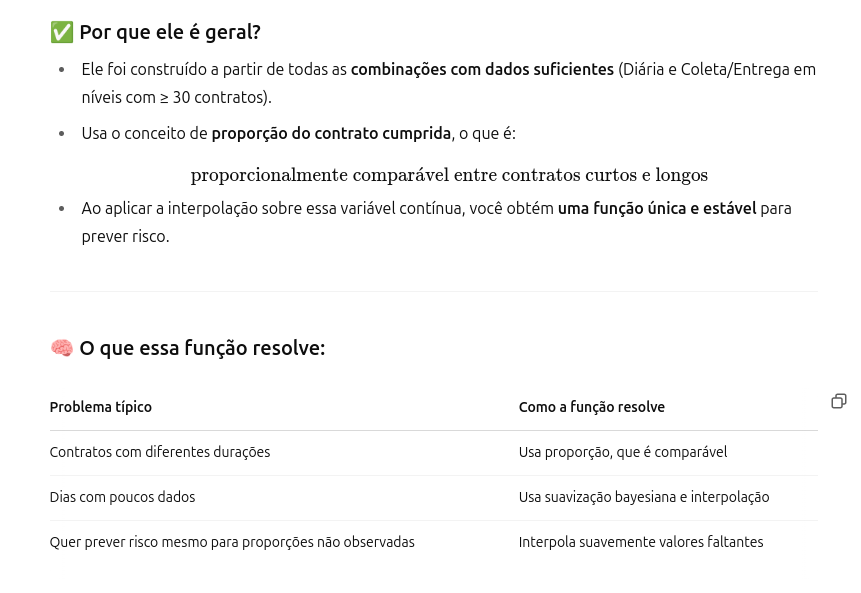

In [24]:
def tabela_risco_comparativa(df, tipo_contrato=None, nivel_px=None, alpha=10):
    df_filtro = df.copy()
    
    if tipo_contrato:
        df_filtro = df_filtro[df_filtro['tipo'] == tipo_contrato]
    if nivel_px:
        df_filtro = df_filtro[df_filtro['nivel_px'] == nivel_px]
    
    p0 = (df['dias_reducao'] > 0).mean()
    resultado = []
    dias_validos = sorted(df_filtro['contract_days_inicial'].dropna().unique())

    for dias_contratados in dias_validos:
        grupo = df_filtro[df_filtro['contract_days_inicial'] == dias_contratados]
        if grupo.empty:
            continue

        for dia_adiantado in range(1, int(dias_contratados) + 1):
            riscos = (grupo['dias_reducao'] >= dia_adiantado)
            p_hat = riscos.mean()
            n = len(riscos)

            if n == 0:
                p_bayes = np.nan
            else:
                p_bayes = (p_hat * n + alpha * p0) / (n + alpha)

            resultado.append({
                'tipo': tipo_contrato,
                'nivel_px': nivel_px,
                'contract_days_inicial': int(dias_contratados),
                'dia_adiantamento': dia_adiantado,
                'risco_estimado_bruto': round(p_hat, 3),
                'risco_estimado_bayesiano': round(p_bayes, 3),
                'n': n
            })

    return pd.DataFrame(resultado)

# Exemplo: gerar para as combinações válidas
combinacoes_validas = df_original.groupby(['tipo', 'nivel_px']).size().reset_index(name='quantidade')
combinacoes_validas = combinacoes_validas[combinacoes_validas['quantidade'] >= 30]

tabelas_comparativas = []
for _, row in combinacoes_validas.iterrows():
    tipo = row['tipo']
    nivel = row['nivel_px']
    df_comp = tabela_risco_comparativa(df_original, tipo_contrato=tipo, nivel_px=nivel)
    tabelas_comparativas.append(df_comp)

df_comparativo = pd.concat(tabelas_comparativas, ignore_index=True)


In [25]:
from scipy.interpolate import interp1d
import numpy as np

# Supondo que você já tem 'df_comparativo' com risco bayesiano
df_comparativo['proporcao_cumprida'] = df_comparativo['dia_adiantamento'] / df_comparativo['contract_days_inicial']
df_comparativo['proporcao_round'] = df_comparativo['proporcao_cumprida'].round(2)

media_por_proporcao = df_comparativo.groupby('proporcao_round').apply(
    lambda x: pd.Series({
        'media_risco_bayesiano': np.average(x['risco_estimado_bayesiano'], weights=x['n']),
        'total_n': x['n'].sum()
    })
).reset_index()

media_por_proporcao = media_por_proporcao.dropna(subset=['media_risco_bayesiano'])

# Interpolador
proporcao_vals = media_por_proporcao['proporcao_round'].values
risco_vals = media_por_proporcao['media_risco_bayesiano'].values
risco_por_proporcao_fn = interp1d(proporcao_vals, risco_vals, kind='linear', fill_value='extrapolate')

# Função preditiva
def estimar_risco_padrao(dia_adiantado, dias_contratados):
    if dias_contratados <= 0:
        return np.nan
    proporcao = dia_adiantado / dias_contratados
    return float(risco_por_proporcao_fn(proporcao))



/tmp/ipykernel_351175/766111185.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  media_por_proporcao = df_comparativo.groupby('proporcao_round').apply(


In [ ]:
from scipy.interpolate import interp1d
import numpy as np

# Supondo que você já tem 'df_comparativo' com risco bayesiano
df_comparativo['proporcao_cumprida'] = df_comparativo['dia_adiantamento'] / df_comparativo['contract_days_inicial']
df_comparativo['proporcao_round'] = df_comparativo['proporcao_cumprida'].round(2)

media_por_proporcao = df_comparativo.groupby('proporcao_round').apply(
    lambda x: pd.Series({
        'media_risco_bayesiano': np.average(x['risco_estimado_bayesiano'], weights=x['n']),
        'total_n': x['n'].sum()
    })
).reset_index()

media_por_proporcao = media_por_proporcao.dropna(subset=['media_risco_bayesiano'])

# Interpolador
proporcao_vals = media_por_proporcao['proporcao_round'].values
risco_vals = media_por_proporcao['media_risco_bayesiano'].values
risco_por_proporcao_fn = interp1d(proporcao_vals, risco_vals, kind='linear', fill_value='extrapolate')

# Função preditiva
def estimar_risco_padrao(dia_adiantado, dias_contratados):
    if dias_contratados <= 0:
        return np.nan
    proporcao = dia_adiantado / dias_contratados
    return float(risco_por_proporcao_fn(proporcao))


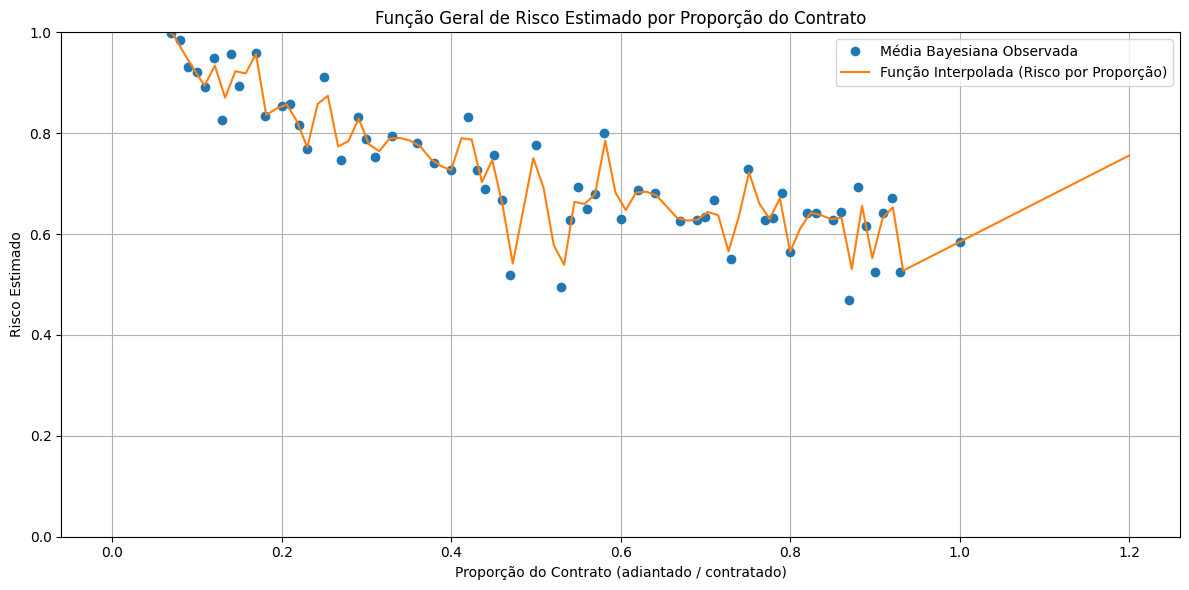

In [26]:
import matplotlib.pyplot as plt

x_plot = np.linspace(0, 1.2, 100)
y_plot = risco_por_proporcao_fn(x_plot)

plt.figure(figsize=(12, 6))
plt.plot(proporcao_vals, risco_vals, 'o', label='Média Bayesiana Observada')
plt.plot(x_plot, y_plot, '-', label='Função Interpolada (Risco por Proporção)')
plt.title('Função Geral de Risco Estimado por Proporção do Contrato')
plt.xlabel('Proporção do Contrato (adiantado / contratado)')
plt.ylabel('Risco Estimado')
plt.grid(True)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
df_original['risco_estimado_padrao'] = df_original.apply(
    lambda row: estimar_risco_padrao(row['contract_days_final'], row['contract_days_inicial']),
    axis=1
)
df_original

,data,freight_id,driver_id,company_id,tipo,nivel_px,contract_days_inicial,contract_days_final,dias_reducao,risco_estimado_padrao
4,2025-04-01,158226,289455,425,Coleta/Entrega,Ouro,5.0,1,4.0,0.854909
5,2025-04-01,158001,305762,3147,Diária,Ouro,4.0,1,3.0,0.911771
6,2025-04-01,157847,317998,788,Diária,Ouro,2.0,1,1.0,0.776863
7,2025-04-01,157728,221202,425,Diária,Ouro,3.0,2,1.0,0.631888
8,2025-04-01,157551,1460,298,Diária,Diamante,4.0,1,3.0,0.911771
...,...,...,...,...,...,...,...,...,...,...
1074,2025-02-01,139401,23569,215,Diária,Ouro,15.0,11,4.0,0.579698
1075,2025-02-01,139394,121628,2103,Diária,Bronze,8.0,5,3.0,0.685750
1078,2025-02-01,139359,10124,36,Coleta/Entrega,Diamante,8.0,7,1.0,0.581549
1079,2025-02-01,139352,153957,1459,Coleta/Entrega,Ouro,3.0,2,1.0,0.631888


In [30]:
# Para um contrato de 10 dias
dias = np.arange(1, 11)
riscos = [estimar_risco_padrao(d, 10) for d in dias]


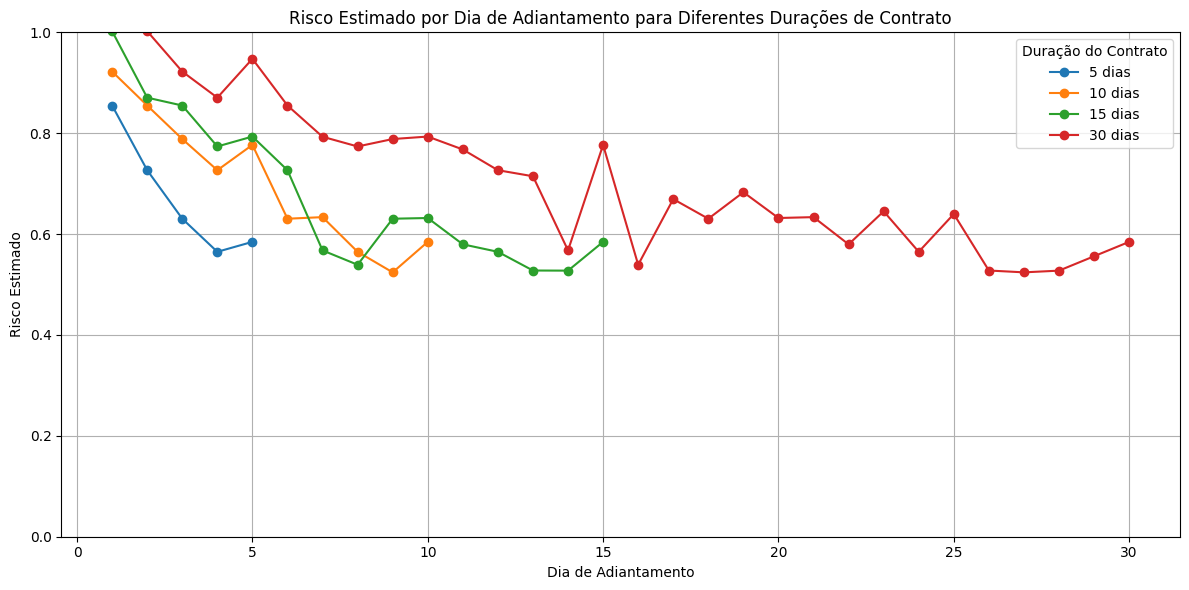

In [31]:
# Gerar gráfico comparativo para várias durações de contrato
duracoes = [5, 10, 15, 30]
plt.figure(figsize=(12, 6))

for duracao in duracoes:
    dias = np.arange(1, duracao + 1)
    riscos = [estimar_risco_padrao(d, duracao) for d in dias]
    plt.plot(dias, riscos, marker='o', label=f'{duracao} dias')

plt.title('Risco Estimado por Dia de Adiantamento para Diferentes Durações de Contrato')
plt.xlabel('Dia de Adiantamento')
plt.ylabel('Risco Estimado')
plt.grid(True)
plt.ylim(0, 1)
plt.legend(title='Duração do Contrato')
plt.tight_layout()
plt.show()


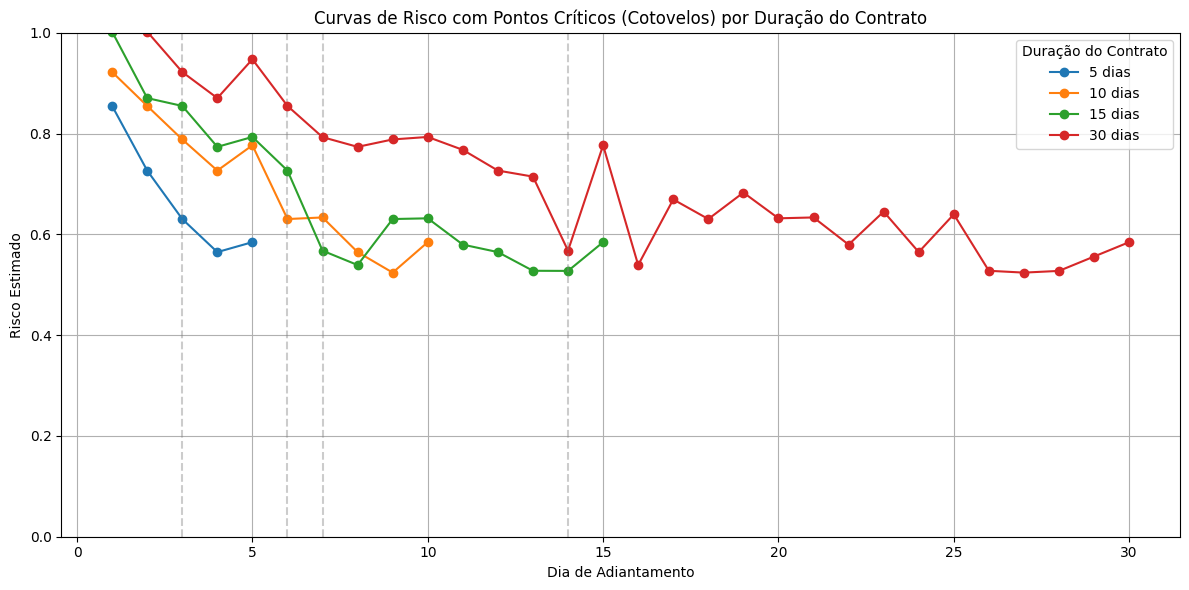

,duracao,cotovelo
0,5,3
1,10,6
2,15,7
3,30,14


In [32]:
# Função para encontrar o ponto de cotovelo usando a distância da linha reta entre primeiro e último ponto
def encontrar_cotovelo(dias, riscos):
    # Normalizar os dados
    x = (dias - np.min(dias)) / (np.max(dias) - np.min(dias))
    y = (riscos - np.min(riscos)) / (np.max(riscos) - np.min(riscos))
    
    # Reta entre o primeiro e o último ponto
    line = np.array([x[-1] - x[0], y[-1] - y[0]])
    line_norm = line / np.linalg.norm(line)

    # Vetores do primeiro ponto até cada ponto da curva
    vecs = np.stack([x - x[0], y - y[0]], axis=1)
    proj_lengths = np.dot(vecs, line_norm)
    proj_points = np.outer(proj_lengths, line_norm) + [x[0], y[0]]

    # Distância euclidiana entre ponto real e sua projeção na reta
    dists = np.linalg.norm(vecs - proj_points, axis=1)
    idx_max = np.argmax(dists)

    return dias[idx_max]

# Analisar cotovelos para cada duração
duracoes = [5, 10, 15, 30]
cotovelos = []

plt.figure(figsize=(12, 6))

for duracao in duracoes:
    dias = np.arange(1, duracao + 1)
    riscos = np.array([estimar_risco_padrao(d, duracao) for d in dias])
    cotovelo = encontrar_cotovelo(dias, riscos)
    cotovelos.append({'duracao': duracao, 'cotovelo': cotovelo})

    plt.plot(dias, riscos, marker='o', label=f'{duracao} dias')
    plt.axvline(x=cotovelo, linestyle='--', color='gray', alpha=0.4)

plt.title('Curvas de Risco com Pontos Críticos (Cotovelos) por Duração do Contrato')
plt.xlabel('Dia de Adiantamento')
plt.ylabel('Risco Estimado')
plt.grid(True)
plt.ylim(0, 1)
plt.legend(title='Duração do Contrato')
plt.tight_layout()
plt.show()

# Tabela com os cotovelos
pd.DataFrame(cotovelos)


In [33]:
def encontrar_limite_minimo_seguro(dias, riscos):
    # Normalizar
    x = (dias - np.min(dias)) / (np.max(dias) - np.min(dias))
    y = (riscos - np.min(riscos)) / (np.max(riscos) - np.min(riscos))
    
    # Linha entre início e fim
    line = np.array([x[-1] - x[0], y[-1] - y[0]])
    line_norm = line / np.linalg.norm(line)

    # Projeções
    vecs = np.stack([x - x[0], y - y[0]], axis=1)
    proj_lengths = np.dot(vecs, line_norm)
    proj_points = np.outer(proj_lengths, line_norm) + [x[0], y[0]]

    # Distância à linha
    dists = np.linalg.norm(vecs - proj_points, axis=1)
    idx_max = np.argmax(dists)

    return dias[idx_max]


dias = np.arange(1, 11)
riscos = [estimar_risco_padrao(d, 10) for d in dias]
limite_minimo_seguro = encontrar_limite_minimo_seguro(dias, riscos)
print(limite_minimo_seguro)  # Deve retornar 6 para contrato de 10 dias


6


In [35]:
# Atualizando nome da função e regenerando a tabela com o novo nome 'dia_virada'

def encontrar_dia_virada(dias, riscos):
    x = (dias - np.min(dias)) / (np.max(dias) - np.min(dias))
    y = (riscos - np.min(riscos)) / (np.max(riscos) - np.min(riscos))
    
    line = np.array([x[-1] - x[0], y[-1] - y[0]])
    line_norm = line / np.linalg.norm(line)

    vecs = np.stack([x - x[0], y - y[0]], axis=1)
    proj_lengths = np.dot(vecs, line_norm)
    proj_points = np.outer(proj_lengths, line_norm) + [x[0], y[0]]

    dists = np.linalg.norm(vecs - proj_points, axis=1)
    idx_max = np.argmax(dists)

    return dias[idx_max]

# Recalcular para cada duração
dias_virada = []

for duracao in duracoes:
    dias = np.arange(1, duracao + 1)
    riscos = np.array([estimar_risco_padrao(d, duracao) for d in dias])
    dia_virada = encontrar_dia_virada(dias, riscos)
    dias_virada.append({'duracao_contrato': duracao, 'dia_virada': dia_virada})

pd.DataFrame(dias_virada)


,duracao_contrato,dia_virada
0,5,3
1,10,6
2,15,7
3,30,14


In [36]:
# Aplicar a função de "dia_virada" para cada duração presente no df_original
duracoes_unicas = sorted(df_original['contract_days_inicial'].dropna().unique())
tabela_virada_completa = []

for duracao in duracoes_unicas:
    if duracao < 2:  # precisa de pelo menos dois dias para haver curva
        continue
    dias = np.arange(1, int(duracao) + 1)
    riscos = np.array([estimar_risco_padrao(d, duracao) for d in dias])
    dia_virada = encontrar_dia_virada(dias, riscos)
    tabela_virada_completa.append({'duracao_contrato': int(duracao), 'dia_virada': dia_virada})

df_dia_virada = pd.DataFrame(tabela_virada_completa).sort_values('duracao_contrato')
df_dia_virada.reset_index(drop=True, inplace=True)
df_dia_virada


,duracao_contrato,dia_virada
0,2,2
1,2,2
2,3,2
3,3,2
4,4,2
5,4,3
6,5,3
7,5,4
8,6,4
9,6,3


In [38]:
dict_dia_virada = df_dia_virada.groupby('duracao_contrato')['dia_virada'].max().to_dict()

def obter_dia_virada(dias_contratados):
    return dict_dia_virada.get(dias_contratados, None)
pd.DataFrame.from_dict(dict_dia_virada, orient='index', columns=['dia_virada']).sort_index()

,dia_virada
2,2
3,2
4,3
5,4
6,4
7,4
8,4
9,5
10,6
11,8


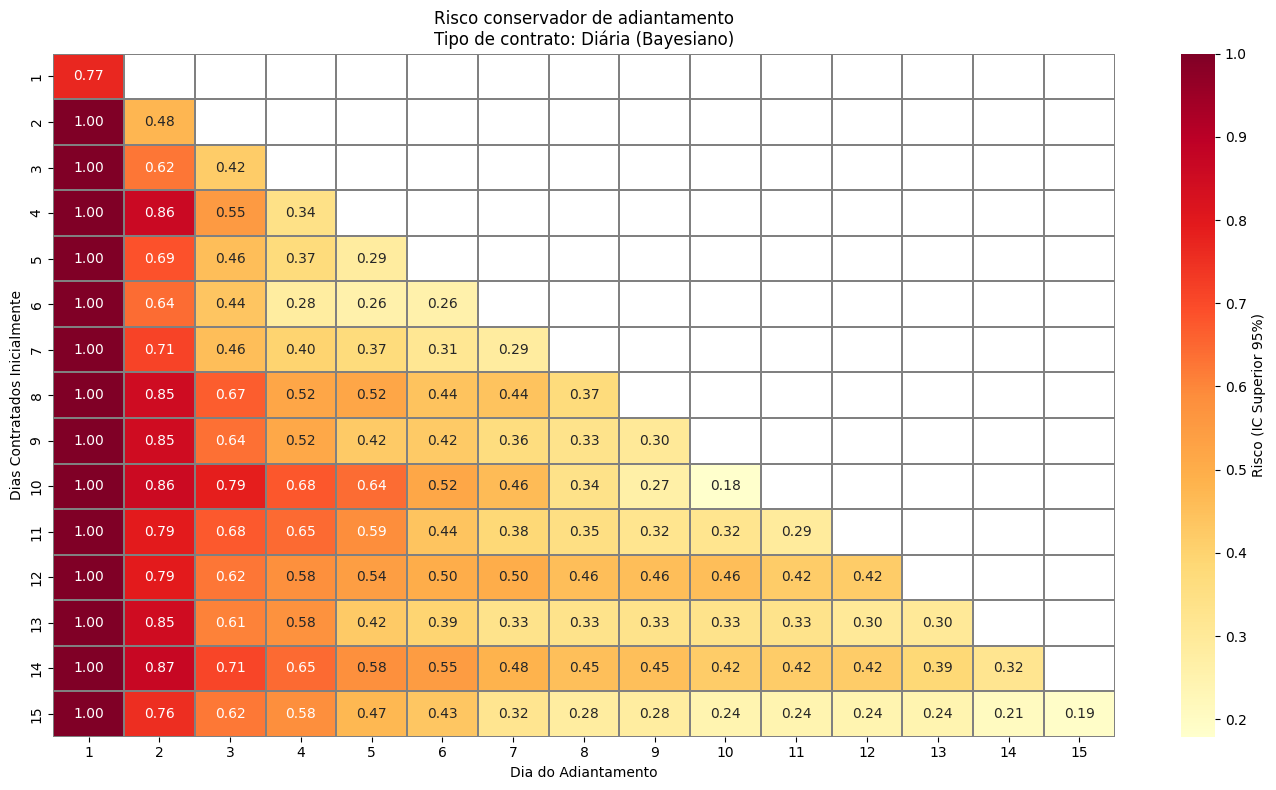

In [15]:
def tabela_risco_bayes(df, tipo_contrato=None, nivel_px=None, alpha=10):
    df_filtro = df.copy()
    
    if tipo_contrato:
        df_filtro = df_filtro[df_filtro['tipo'] == tipo_contrato]
    if nivel_px:
        df_filtro = df_filtro[df_filtro['nivel_px'] == nivel_px]
    
    # Prior global (proporção de contratos com alguma redução)
    p0 = (df['dias_reducao'] > 0).mean()
    
    resultado = []

    dias_validos = sorted(df_filtro['contract_days_inicial'].dropna().unique())

    for dias_contratados in dias_validos:
        grupo = df_filtro[df_filtro['contract_days_inicial'] == dias_contratados]
        if grupo.empty:
            continue

        for dia_adiantado in range(1, int(dias_contratados) + 1):
            riscos = (grupo['dias_reducao'] >= dia_adiantado)
            p_hat = riscos.mean()
            n = len(riscos)

            if n == 0:
                p_bayes = np.nan
            else:
                p_bayes = (p_hat * n + alpha * p0) / (n + alpha)

            resultado.append({
                'contract_days_inicial': int(dias_contratados),
                'dia_adiantamento': dia_adiantado,
                'risco_estimado_bruto': round(p_hat, 3),
                'risco_estimado_bayesiano': round(p_bayes, 3),
                'n': n
            })

    df_final = pd.DataFrame(resultado)
    df_final = df_final.drop_duplicates(
        subset=['contract_days_inicial', 'dia_adiantamento'], keep='first'
    )

    return df_final

df_bayes_diaria = tabela_risco_bayes(df_original, tipo_contrato='Diária')

df_heat_bayes = df_bayes_diaria.pivot(
    index='contract_days_inicial',
    columns='dia_adiantamento',
    values='risco_estimado_bayesiano'
)
df_bayes_diaria_ouro = tabela_risco_bayes(df_original, tipo_contrato='Diária', nivel_px='Ouro')

plot_heatmap_limite_superior(df_heat_bayes, tipo='Diária (Bayesiano)')


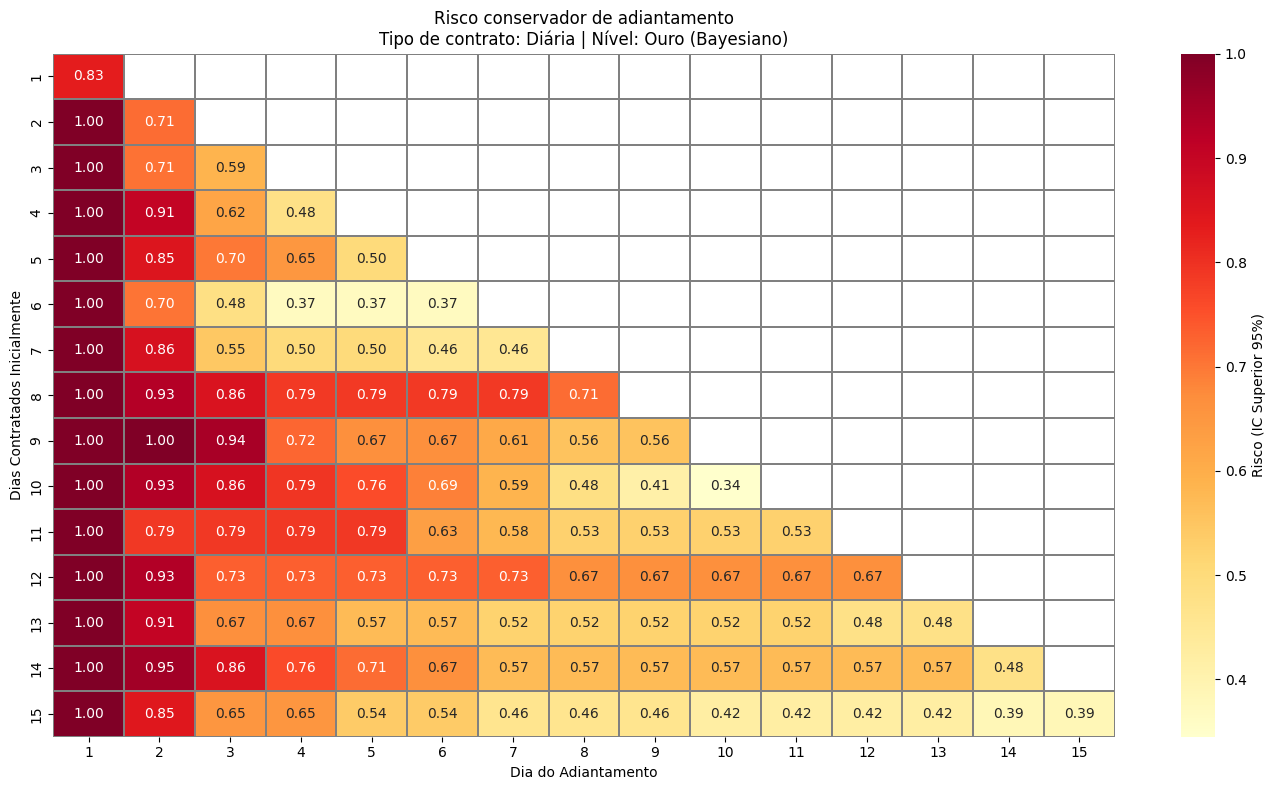

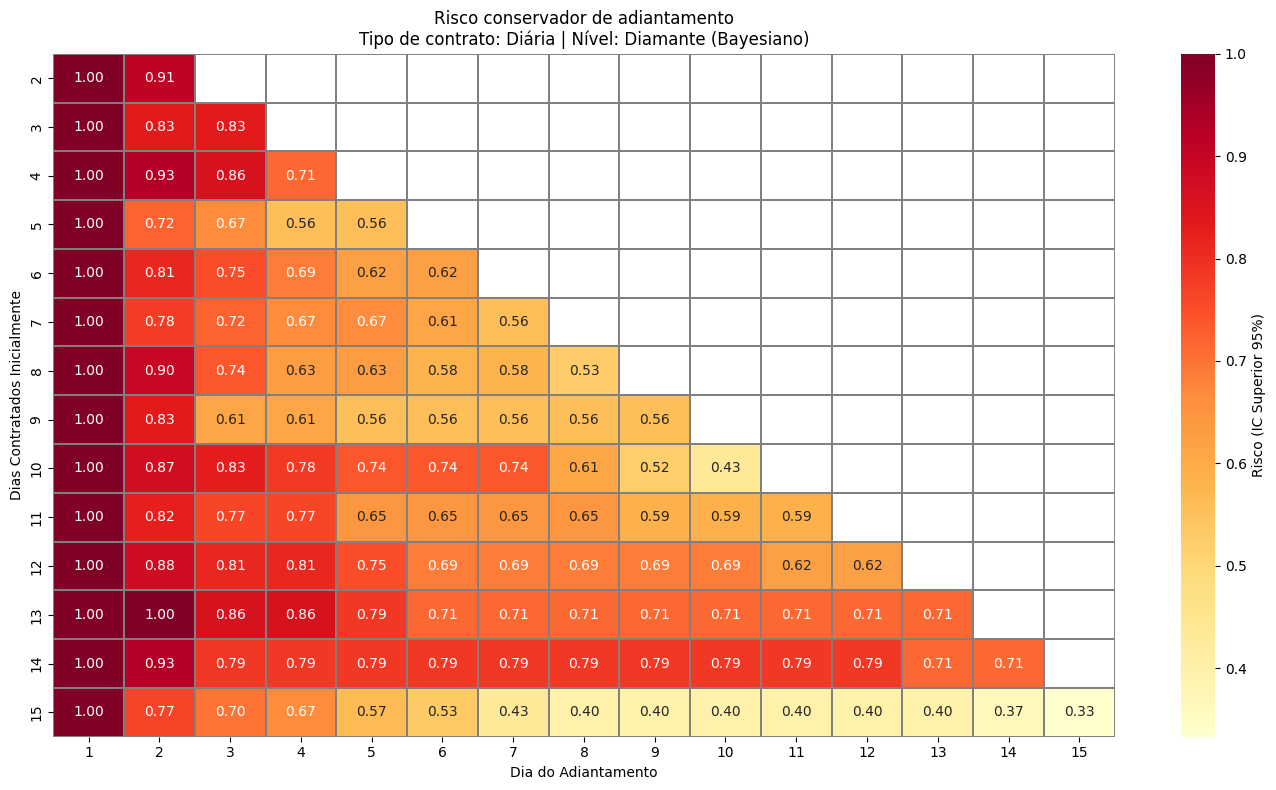

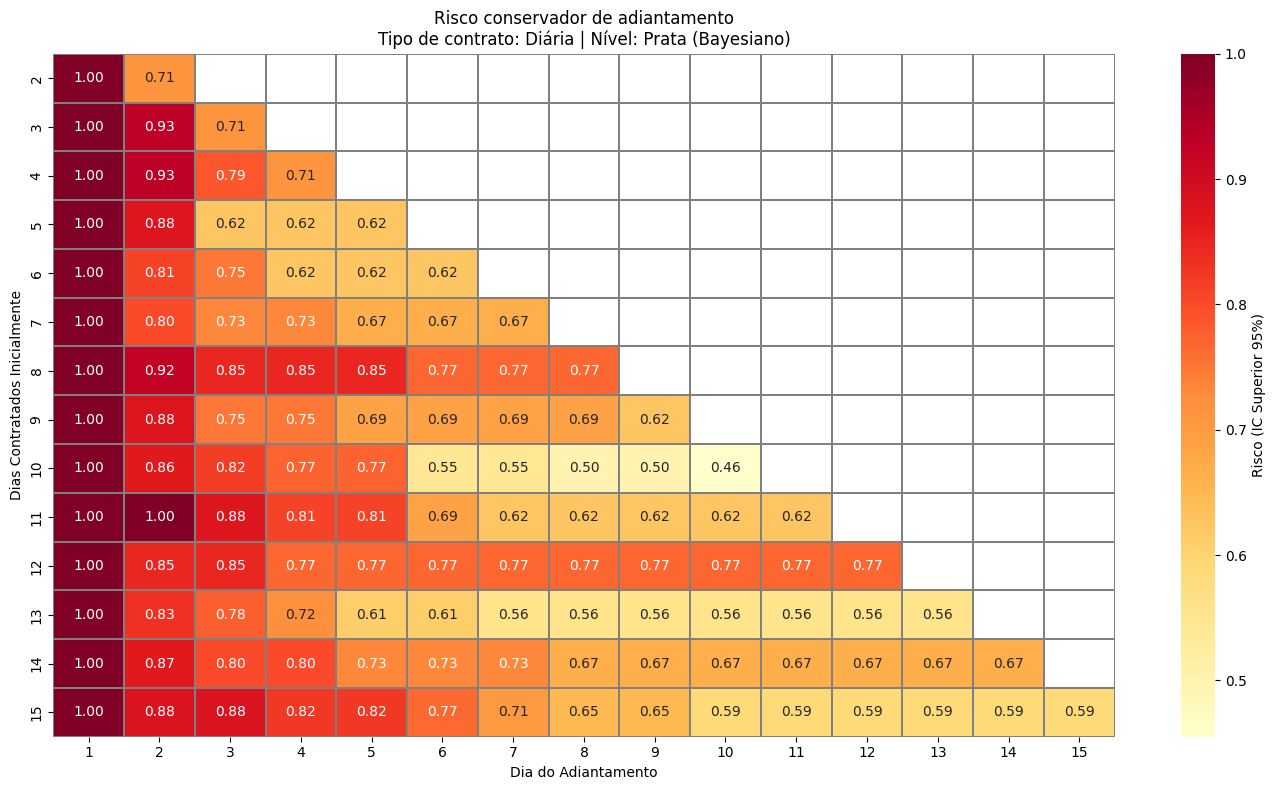

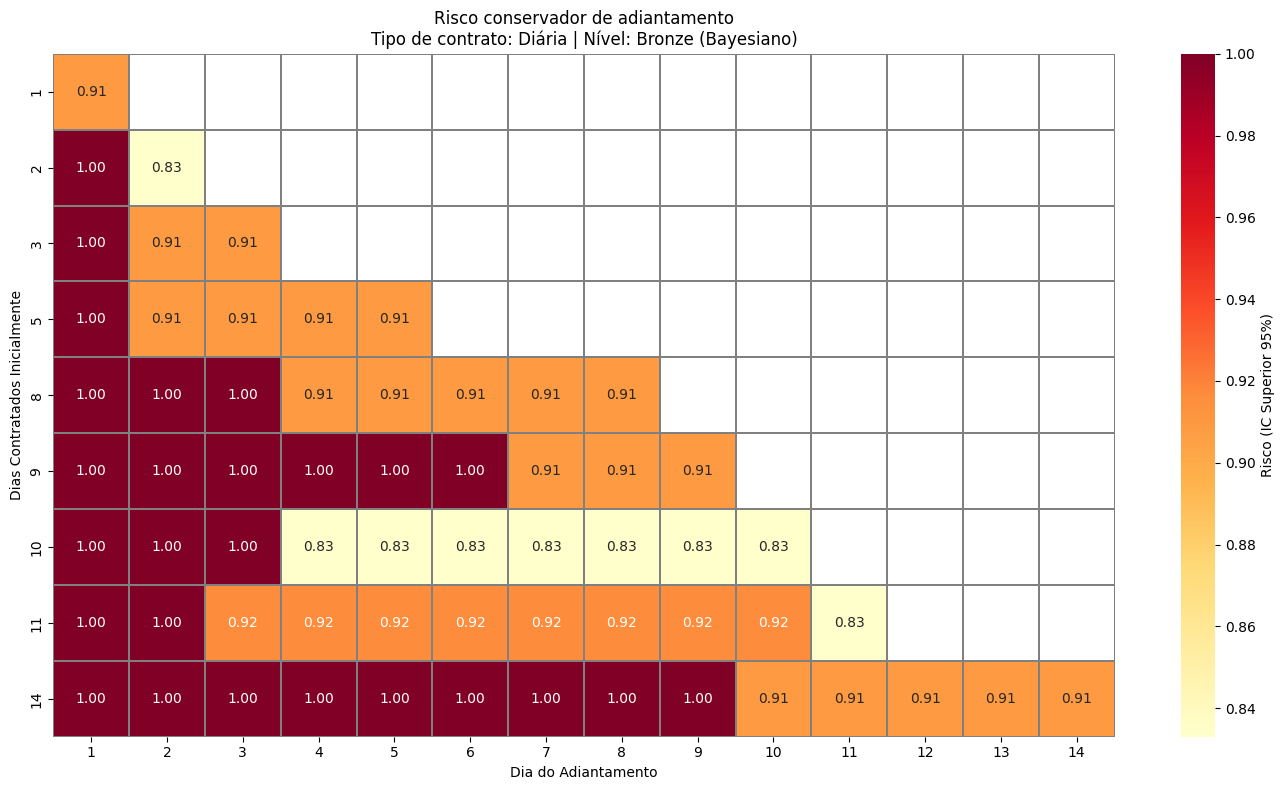

In [16]:
niveis_diaria = df_original[df_original['tipo'] == 'Diária']['nivel_px'].dropna().unique()
for nivel in niveis_diaria:
    df_bayes = tabela_risco_bayes(df_original, tipo_contrato='Diária', nivel_px=nivel)

    df_heat = df_bayes.pivot(
        index='contract_days_inicial',
        columns='dia_adiantamento',
        values='risco_estimado_bayesiano'
    )

    plot_heatmap_limite_superior(df_heat, tipo=f'Diária | Nível: {nivel} (Bayesiano)')


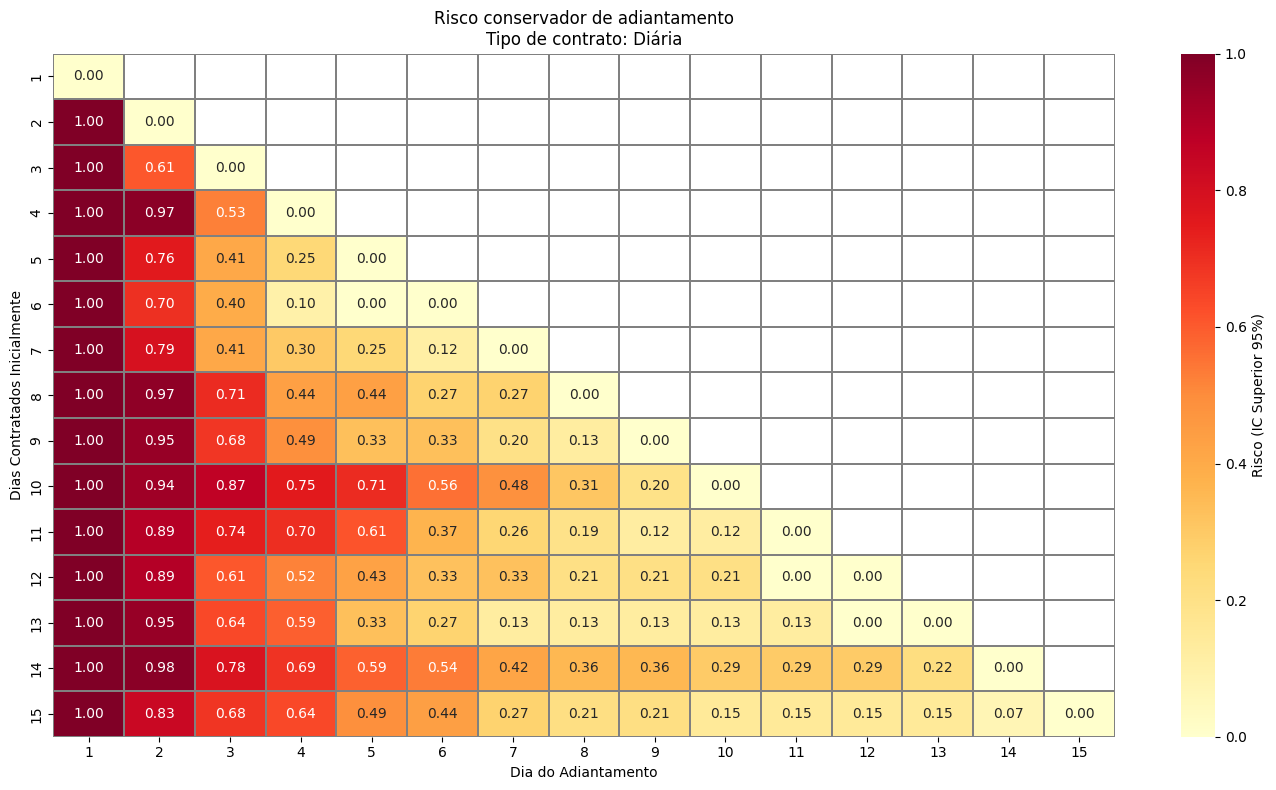

In [5]:
import pandas as pd
import numpy as np

def tabela_risco_com_limite_superior(df, tipo_contrato, z=1.96):
    df_filtro = df[df['tipo'] == tipo_contrato].copy()
    resultado = []

    dias_validos = sorted(df_filtro['contract_days_inicial'].dropna().unique())

    for dias_contratados in dias_validos:
        grupo = df_filtro[df_filtro['contract_days_inicial'] == dias_contratados]
        if grupo.empty:
            continue

        for dia_adiantado in range(1, int(dias_contratados) + 1):
            riscos = (grupo['dias_reducao'] >= dia_adiantado)
            p̂ = riscos.mean()
            n = len(riscos)

            if n == 0:
                erro = np.nan
                ic_sup = np.nan
            else:
                erro = z * np.sqrt((p̂ * (1 - p̂)) / n)
                ic_sup = min(p̂ + erro, 1.0)  # risco máximo nunca ultrapassa 100%

            resultado.append({
                'contract_days_inicial': int(dias_contratados),
                'dia_adiantamento': dia_adiantado,
                'risco_estimado': round(p̂, 3),
                'limite_superior_95': round(ic_sup, 3),
                'n': n
            })

    df_final = pd.DataFrame(resultado)
    df_final = df_final.drop_duplicates(
        subset=['contract_days_inicial', 'dia_adiantamento'], keep='first'
    )

    return df_final
df_risco_limite = tabela_risco_com_limite_superior(df_original, tipo_contrato='Diária')

df_heat = df_risco_limite.pivot(
    index='contract_days_inicial',
    columns='dia_adiantamento',
    values='limite_superior_95'
)


def plot_heatmap_limite_superior(df_heat, tipo):
    plt.figure(figsize=(14, 8))
    sns.heatmap(df_heat, cmap='YlOrRd', linewidths=0.2, linecolor='gray',
                annot=True, fmt=".2f", cbar_kws={'label': 'Risco (IC Superior 95%)'})
    plt.title(f'Risco conservador de adiantamento\nTipo de contrato: {tipo}')
    plt.xlabel('Dia do Adiantamento')
    plt.ylabel('Dias Contratados Inicialmente')
    plt.tight_layout()
    plt.show()

plot_heatmap_limite_superior(df_heat, tipo='Diária')



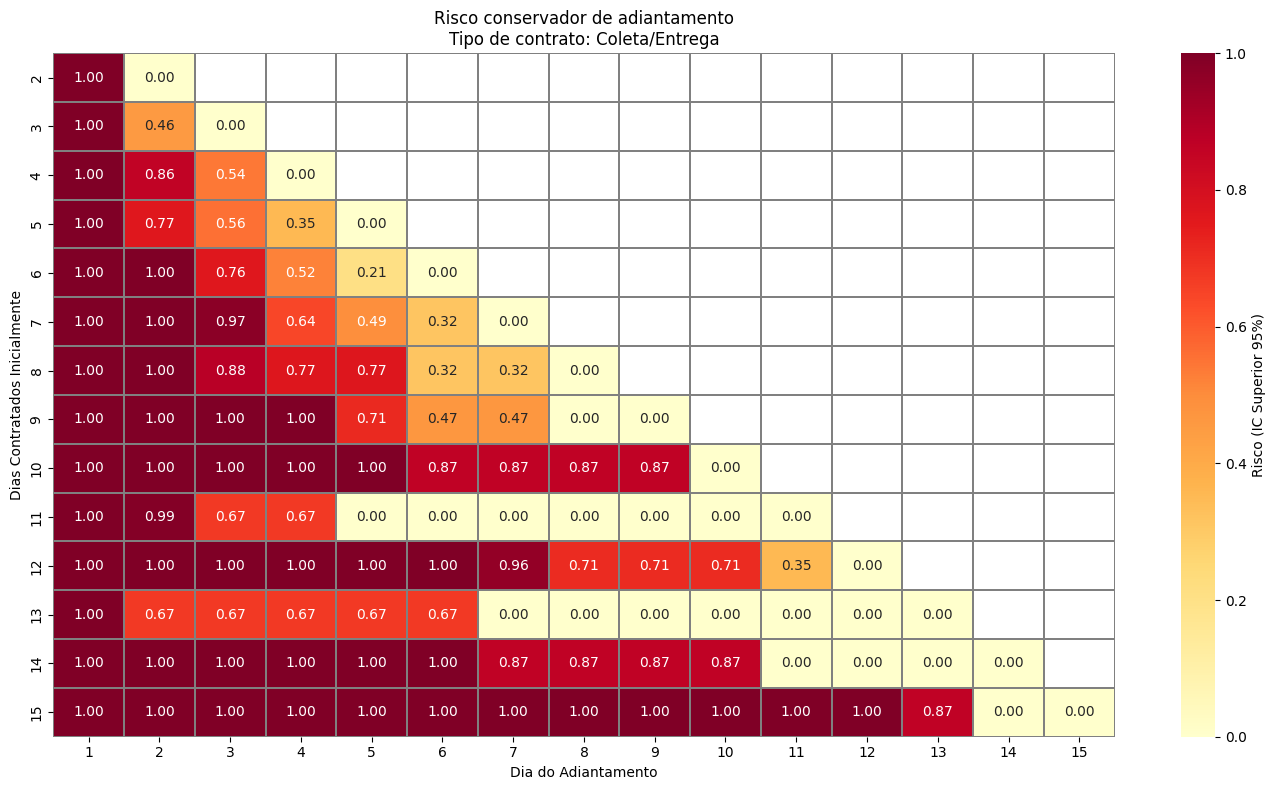

In [9]:
def gerar_heatmap_por_tipo(df, tipo):
    df_risco = tabela_risco_com_limite_superior(df, tipo_contrato=tipo)

    df_heat = df_risco.pivot(
        index='contract_days_inicial',
        columns='dia_adiantamento',
        values='limite_superior_95'
    )

    plot_heatmap_limite_superior(df_heat, tipo=tipo)
gerar_heatmap_por_tipo(df_original, tipo='Coleta/Entrega')

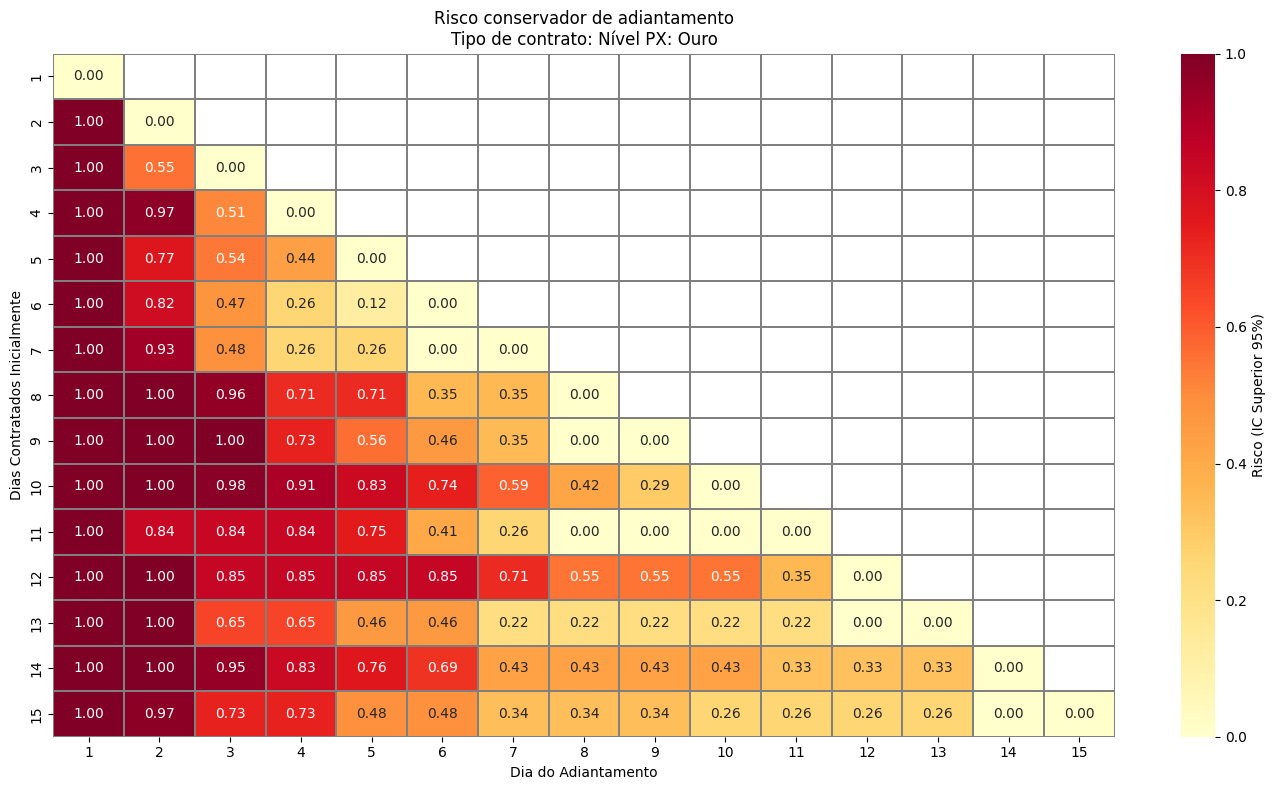

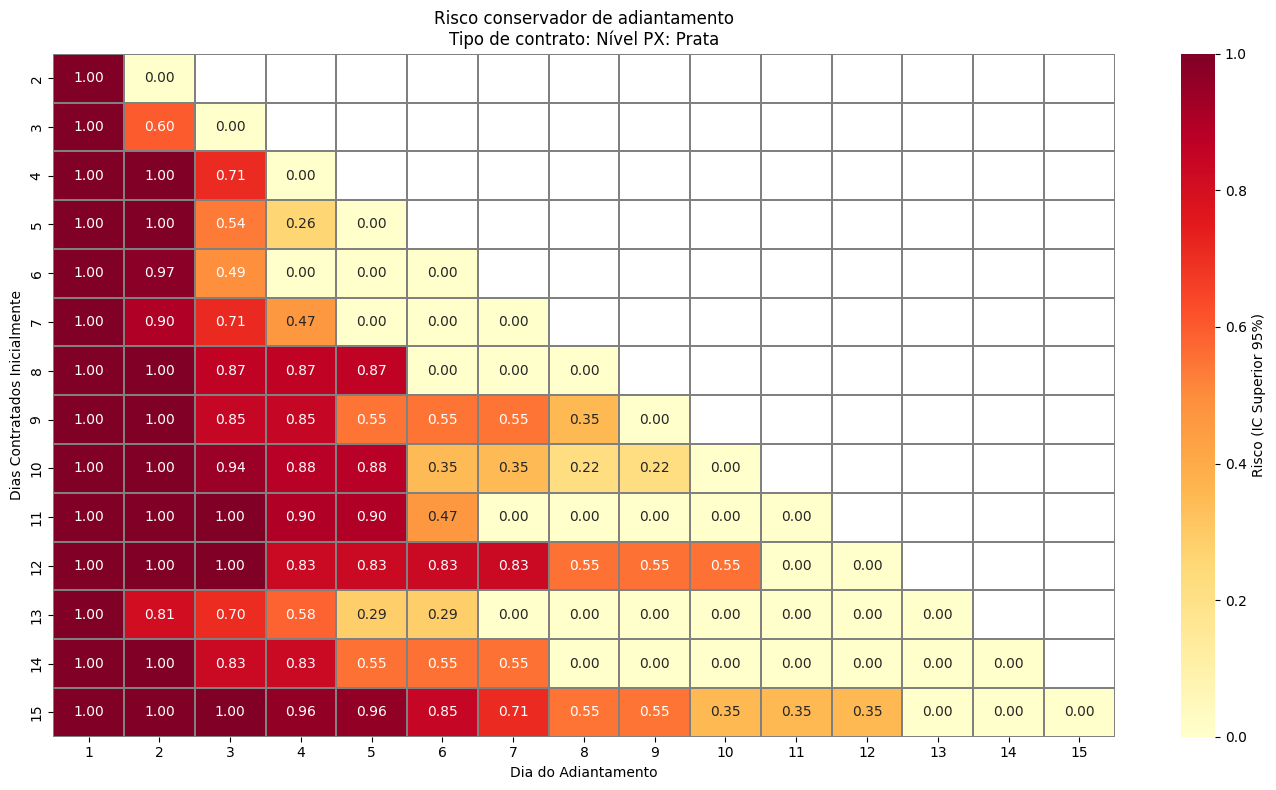

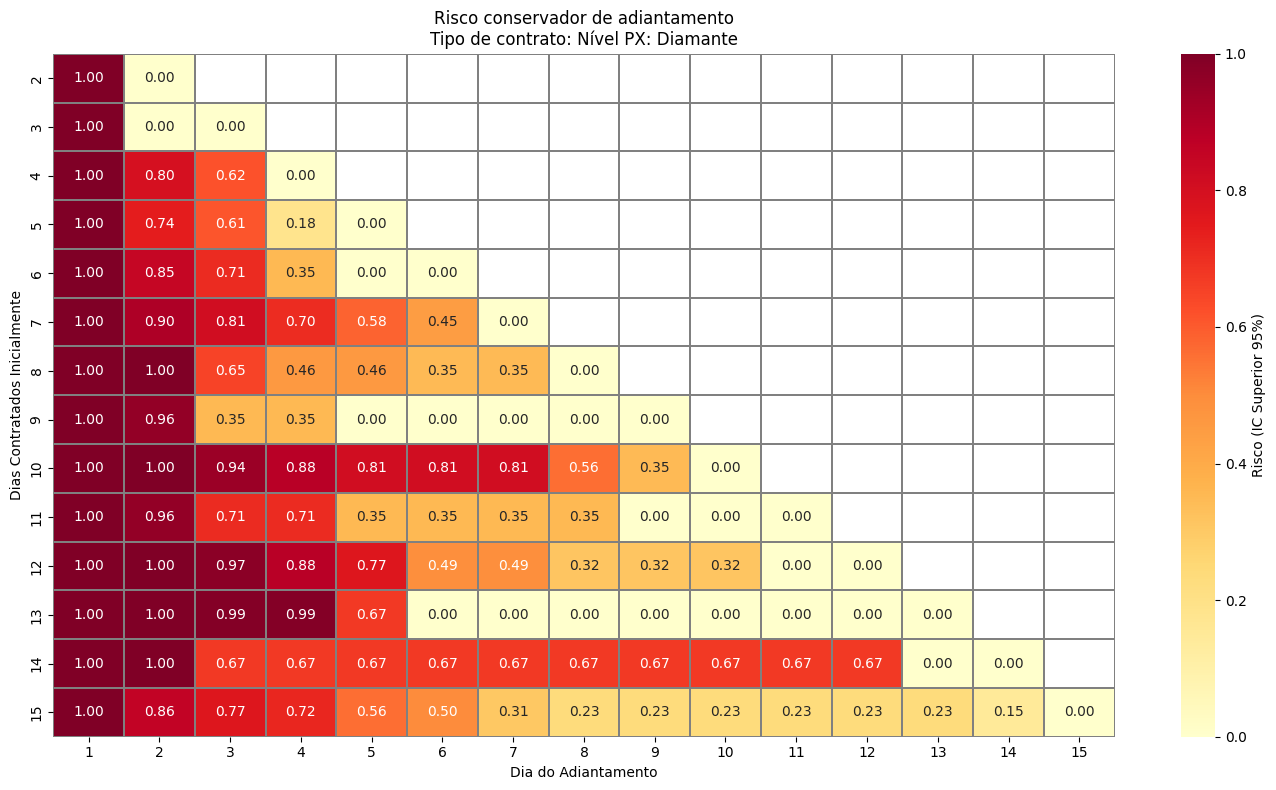

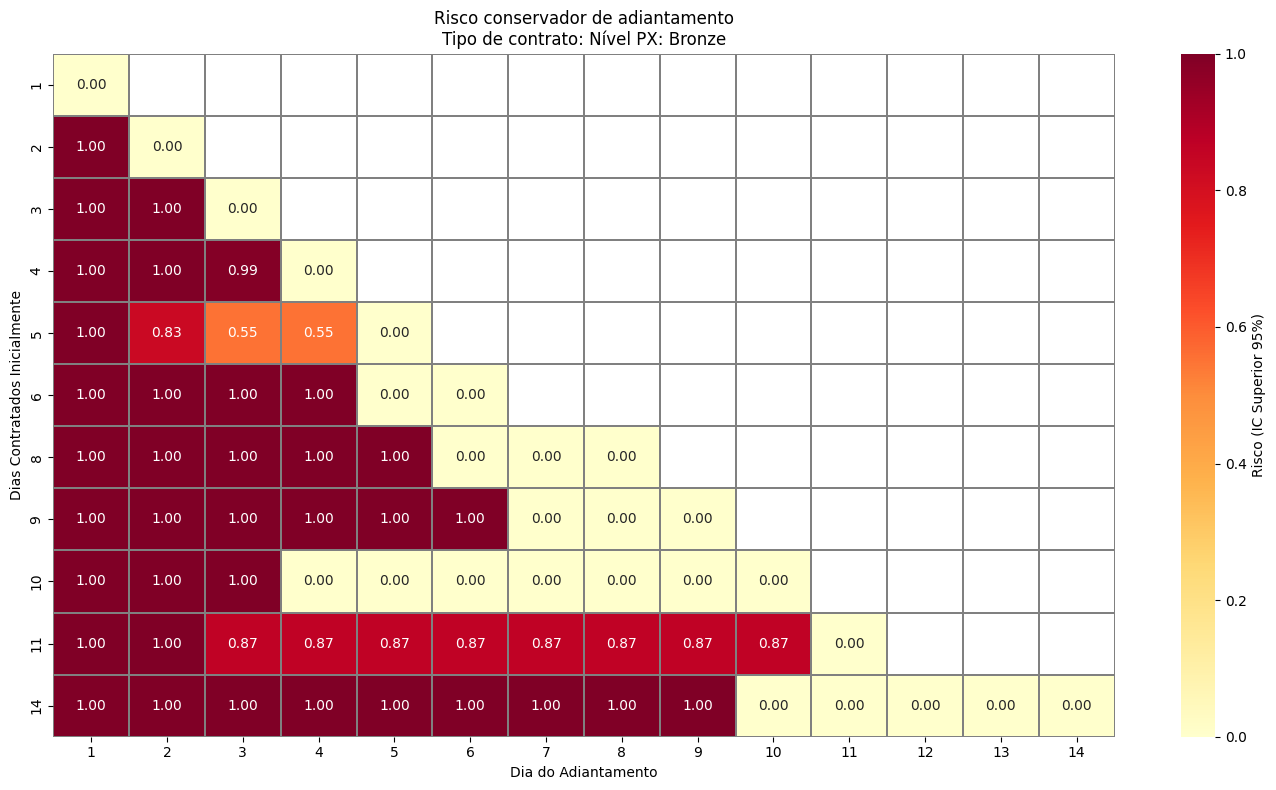

In [11]:
def tabela_risco_com_limite_superior_por_nivel(df, nivel_px, z=1.96):
    df_filtro = df[df['nivel_px'] == nivel_px].copy()
    resultado = []

    dias_validos = sorted(df_filtro['contract_days_inicial'].dropna().unique())

    for dias_contratados in dias_validos:
        grupo = df_filtro[df_filtro['contract_days_inicial'] == dias_contratados]
        if grupo.empty:
            continue

        for dia_adiantado in range(1, int(dias_contratados) + 1):
            riscos = (grupo['dias_reducao'] >= dia_adiantado)
            p̂ = riscos.mean()
            n = len(riscos)

            if n == 0:
                erro = np.nan
                ic_sup = np.nan
            else:
                erro = z * np.sqrt((p̂ * (1 - p̂)) / n)
                ic_sup = min(p̂ + erro, 1.0)

            resultado.append({
                'contract_days_inicial': int(dias_contratados),
                'dia_adiantamento': dia_adiantado,
                'risco_estimado': round(p̂, 3),
                'limite_superior_95': round(ic_sup, 3),
                'n': n
            })

    df_final = pd.DataFrame(resultado)
    df_final = df_final.drop_duplicates(
        subset=['contract_days_inicial', 'dia_adiantamento'], keep='first'
    )

    return df_final

def gerar_heatmap_por_nivel(df, nivel):
    df_risco = tabela_risco_com_limite_superior_por_nivel(df, nivel_px=nivel)

    df_heat = df_risco.pivot(
        index='contract_days_inicial',
        columns='dia_adiantamento',
        values='limite_superior_95'
    )

    plot_heatmap_limite_superior(df_heat, tipo=f'Nível PX: {nivel}')

gerar_heatmap_por_nivel(df_original, nivel='Ouro')
gerar_heatmap_por_nivel(df_original, nivel='Prata')
gerar_heatmap_por_nivel(df_original, nivel='Diamante')
gerar_heatmap_por_nivel(df_original, nivel='Bronze')

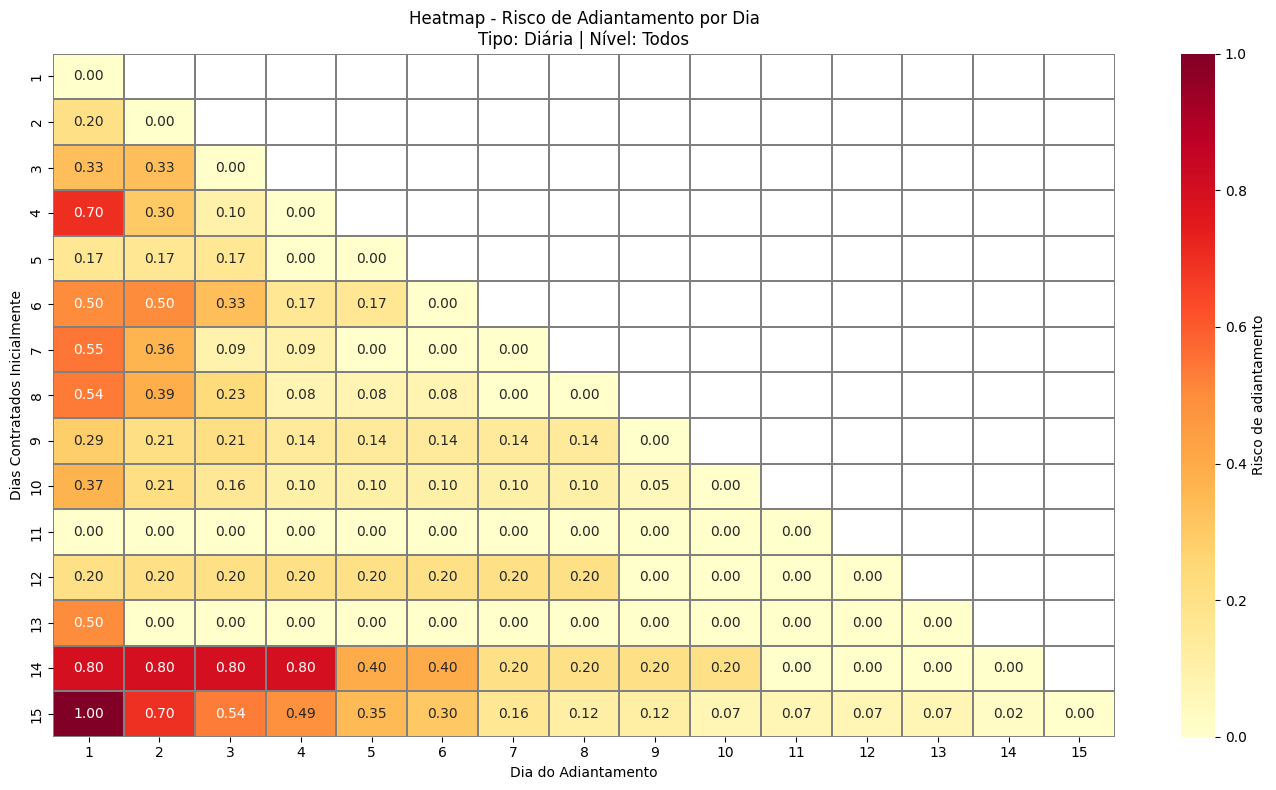

In [124]:
def tabela_risco_por_dia(df, tipo_contrato):
    df_filtro = df[df['tipo'] == tipo_contrato].copy()

    resultado = {}

    dias_validos = sorted(df_filtro['contract_days_inicial'].dropna().unique())
    
    for dias_contratados in dias_validos:
        grupo = df_filtro[df_filtro['contract_days_inicial'] == dias_contratados]
        if grupo.empty:
            continue

        linha = {}
        for dia_adiantado in range(1, int(dias_contratados) + 1):
            risco = (grupo['dias_reducao'] >= dia_adiantado).mean()
            linha[dia_adiantado] = round(risco, 3)

        resultado[int(dias_contratados)] = linha

    df_risco = pd.DataFrame.from_dict(resultado, orient='index')
    df_risco.index.name = 'contract_days_inicial'
    df_risco.columns.name = 'dia_adiantamento'

    return df_risco.dropna(how='all')

df_risco_diaria = tabela_risco_por_dia(df_original, tipo_contrato='Diária')
df_risco_coleta = tabela_risco_por_dia(df_original, tipo_contrato='Coleta/Entrega')
df_risco_ajudante = tabela_risco_por_dia(df_original, tipo_contrato='Ajudante')


def plot_heatmap_risco(df_risco, tipo, nivel):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(14, 8))
    sns.heatmap(df_risco, cmap='YlOrRd', linewidths=0.2, linecolor='gray',
                annot=True, fmt=".2f", cbar_kws={'label': 'Risco de adiantamento'})
    plt.title(f'Heatmap - Risco de Adiantamento por Dia\nTipo: {tipo} | Nível: {nivel}')
    plt.xlabel('Dia do Adiantamento')
    plt.ylabel('Dias Contratados Inicialmente')
    plt.tight_layout()
    plt.show()

plot_heatmap_risco(df_risco_diaria, tipo='Diária', nivel='Todos')

In [122]:
df_risco = tabela_risco_por_dia(df_original, tipo_contrato='Diária')
df_risco

dia_adiantamento,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
contract_days_inicial,,,,,,,,,,,,,,,
1,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.200,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.333,0.333,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.700,0.300,0.100,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.167,0.167,0.167,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.500,0.500,0.333,0.167,0.167,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.545,0.364,0.091,0.091,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.538,0.385,0.231,0.077,0.077,0.077,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.286,0.214,0.214,0.143,0.143,0.143,0.143,0.143,0.000,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
df_original[
    (df_original['tipo'] == 'Diária') &
    (df_original['contract_days_inicial'] == 1)
]['dias_reducao'].value_counts()

Series([], Name: count, dtype: int64)

In [113]:
def tabela_risco_por_dia(df, tipo_contrato, nivel_px=None, max_dias=30):
    df_filtro = df[df['tipo'] == tipo_contrato].copy()
    if nivel_px:
        df_filtro = df_filtro[df_filtro['nivel_px'] == nivel_px]

    resultado = {}

    for dias_contratados in sorted(df_filtro['contract_days_inicial'].unique()):
        grupo = df_filtro[df_filtro['contract_days_inicial'] == dias_contratados]
        if grupo.empty:
            continue

        linha = {}
        for dia_adiantado in range(1, dias_contratados + 1):
            dias_restantes = dias_contratados - dia_adiantado
            if dias_restantes <= 0:
                risco = 0.0
            else:
                risco = (grupo['dias_reducao'] >= dias_restantes).mean()
            linha[dia_adiantado] = round(risco, 3)

        resultado[dias_contratados] = linha

    df_risco = pd.DataFrame.from_dict(resultado, orient='index')
    df_risco.index.name = 'contract_days_inicial'
    df_risco.columns.name = 'dia_adiantamento'
    return df_risco

df_risco = tabela_risco_por_dia(df_original, tipo_contrato='Coleta/Entrega', nivel_px='Ouro')
df_risco

TypeError: 'numpy.float64' object cannot be interpreted as an integer


Contrato tipo: Coleta/Entrega | Nível: Ouro

A média global de risco de adiantamento é 52%

Em contratos de 10 dias, o risco ultrapassa 50% a partir do 4º dia

Em contratos de 5 dias, o risco de erro atinge 100% no último dia

Recomendação: aplicar política de adiantamento parcial ou escalonada após o 3º dia, principalmente para contratos de até 10 dias.

2. 📊 Slide com o heatmap (zoomado) + interpretação
Exemplo de texto para o slide:

Contratos de até 10 dias têm alta chance de sofrer reduções de até 4 dias

Reduções acima de 10 dias são raras para contratos com menos de 15 dias

Há padrões fortes de corte próximos ao final dos contratos

In [56]:
df_original.dias_reducao.describe()

count    895.000000
mean       4.086034
std        4.946229
min        0.500000
25%        1.000000
50%        2.000000
75%        5.000000
max       32.000000
Name: dias_reducao, dtype: float64

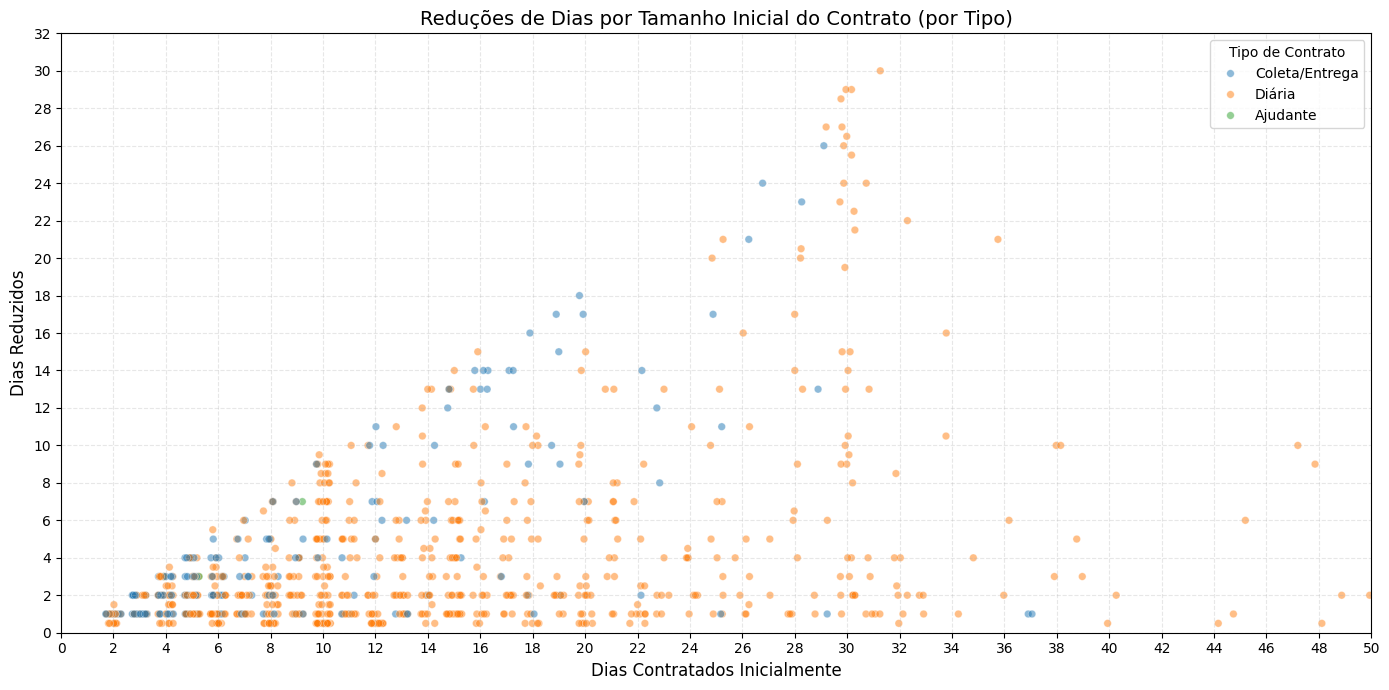

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cria jitter manual
np.random.seed(42)
df_plot = df_original.copy()
df_plot['jittered_x'] = df_plot['contract_days_inicial'] + np.random.uniform(-0.3, 0.3, size=len(df_plot))

# Limites
x_min = 0
x_max = 50
x_ticks = np.arange(x_min, x_max + 1, 2)

y_min = 0
y_max = int(df_plot['dias_reducao'].max())
y_ticks = np.arange(y_min, y_max + 1, 2)

# Plot
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df_plot,
    x='jittered_x',
    y='dias_reducao',
    hue='tipo',
    alpha=0.5,
    s=30
)

# Eixos e estética
plt.xticks(ticks=x_ticks, fontsize=10)
plt.yticks(ticks=y_ticks, fontsize=10)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.title('Reduções de Dias por Tamanho Inicial do Contrato (por Tipo)', fontsize=14)
plt.xlabel('Dias Contratados Inicialmente', fontsize=12)
plt.ylabel('Dias Reduzidos', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Tipo de Contrato')
plt.tight_layout()
plt.show()




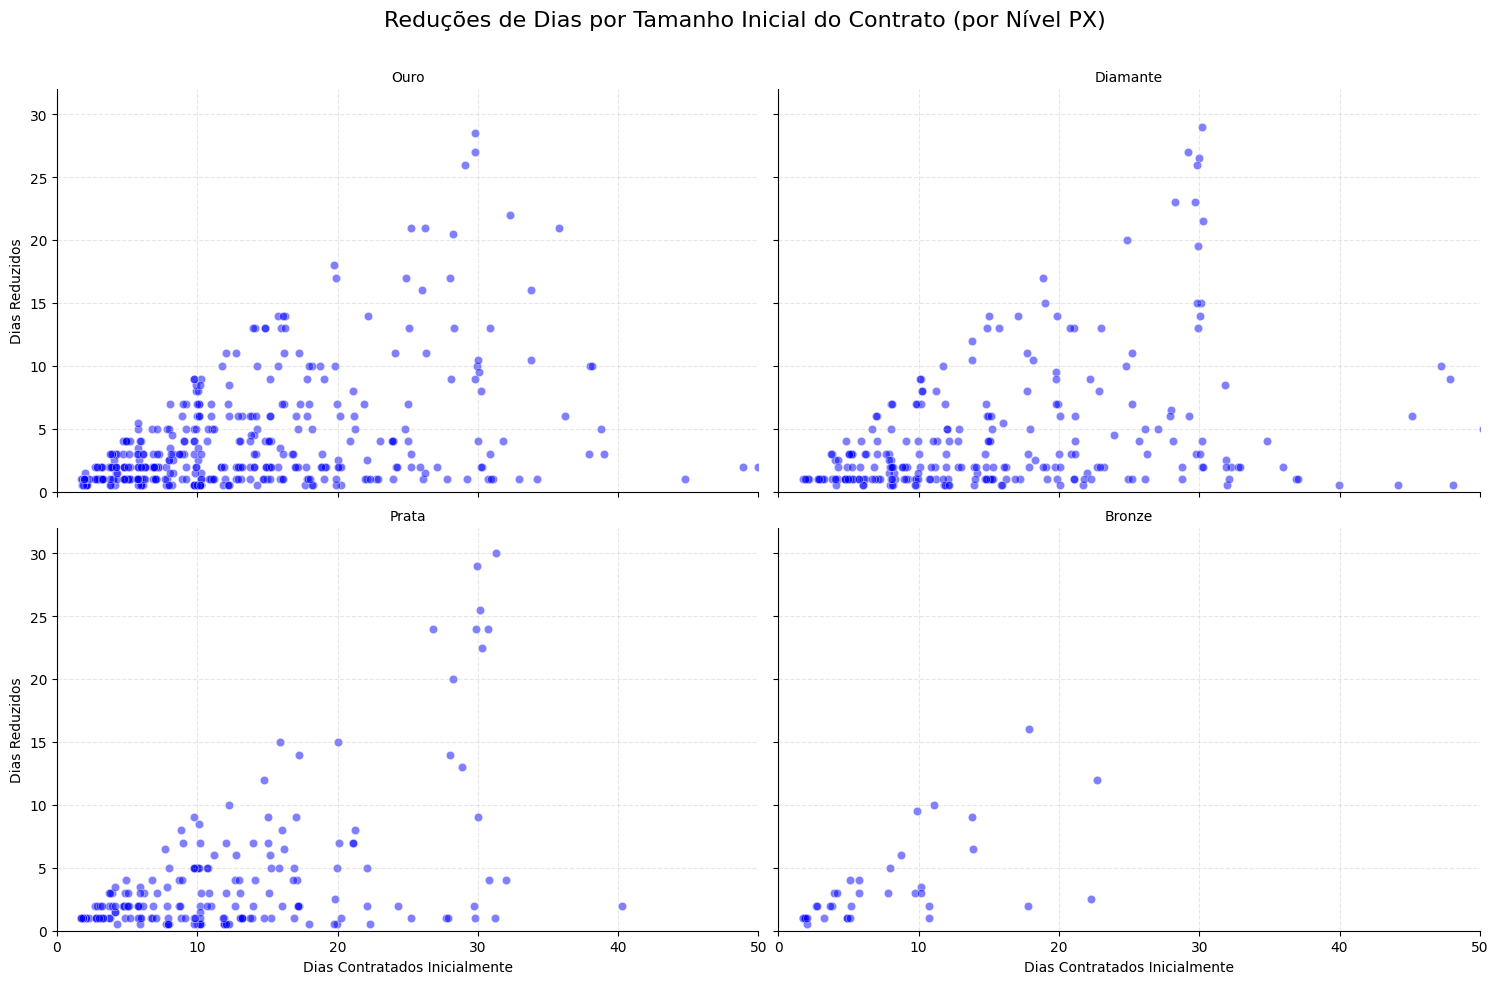

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Jitter manual
np.random.seed(42)
df_plot = df_original.copy()
df_plot['jittered_x'] = df_plot['contract_days_inicial'] + np.random.uniform(-0.3, 0.3, size=len(df_plot))

# FacetGrid
g = sns.FacetGrid(df_plot, col="nivel_px", col_wrap=2, height=5, aspect=1.5)
g.map_dataframe(
    sns.scatterplot,
    x="jittered_x",
    y="dias_reducao",
    alpha=0.5,
    color='blue'
)

# Ajustes visuais
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Dias Contratados Inicialmente", "Dias Reduzidos")
for ax in g.axes.flat:
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_xlim(0, 50)
    ax.set_ylim(0, df_plot['dias_reducao'].max())
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Reduções de Dias por Tamanho Inicial do Contrato (por Nível PX)", fontsize=16)
plt.show()


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Arredonda para o intervalo mais próximo de 0.5
df_original['dias_reducao'] = (df_original['dias_reducao'] * 2).round() / 2

# Agrupa e conta ocorrências
tabela = (
    df_original
    .groupby(['contract_days_inicial', 'dias_reducao'])
    .size()
    .reset_index(name='contagem')
)

# Soma total por cada valor de dias contratados
totais = (
    tabela
    .groupby('contract_days_inicial')['contagem']
    .sum()
    .reset_index(name='total')
)

# Junta os totais à tabela de contagens
tabela = tabela.merge(totais, on='contract_days_inicial')
tabela['proporcao'] = tabela['contagem'] / tabela['total']

# Pivot para tabela final
tabela_pivot = tabela.pivot(
    index='contract_days_inicial',
    columns='dias_reducao',
    values='proporcao'
).fillna(0).sort_index(axis=1)


tabela_pivot

dias_reducao,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,23.0,24.0,25.5,26.0,26.5,27.0,28.5,29.0,30.0,32.0
contract_days_inicial,,,,,,,,,,,,,,,,,,,,,
2,0.159091,0.818182,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,0.0
3,0.000000,0.692308,0.000000,0.307692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,0.0
4,0.102041,0.204082,0.081633,0.285714,0.061224,0.244898,0.020408,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,0.0
5,0.000000,0.418182,0.000000,0.254545,0.000000,0.163636,0.000000,0.163636,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,0.0
6,0.145455,0.290909,0.000000,0.236364,0.018182,0.163636,0.036364,0.072727,0.000000,0.018182,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,0.0
7,0.000000,0.352941,0.000000,0.294118,0.000000,0.147059,0.000000,0.058824,0.000000,0.088235,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,0.0
8,0.220000,0.120000,0.080000,0.140000,0.100000,0.100000,0.040000,0.000000,0.020000,0.100000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,0.0
9,0.000000,0.233333,0.000000,0.233333,0.000000,0.133333,0.000000,0.166667,0.000000,0.033333,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,0.0
10,0.268293,0.097561,0.048780,0.048780,0.012195,0.073171,0.024390,0.036585,0.000000,0.097561,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,0.0


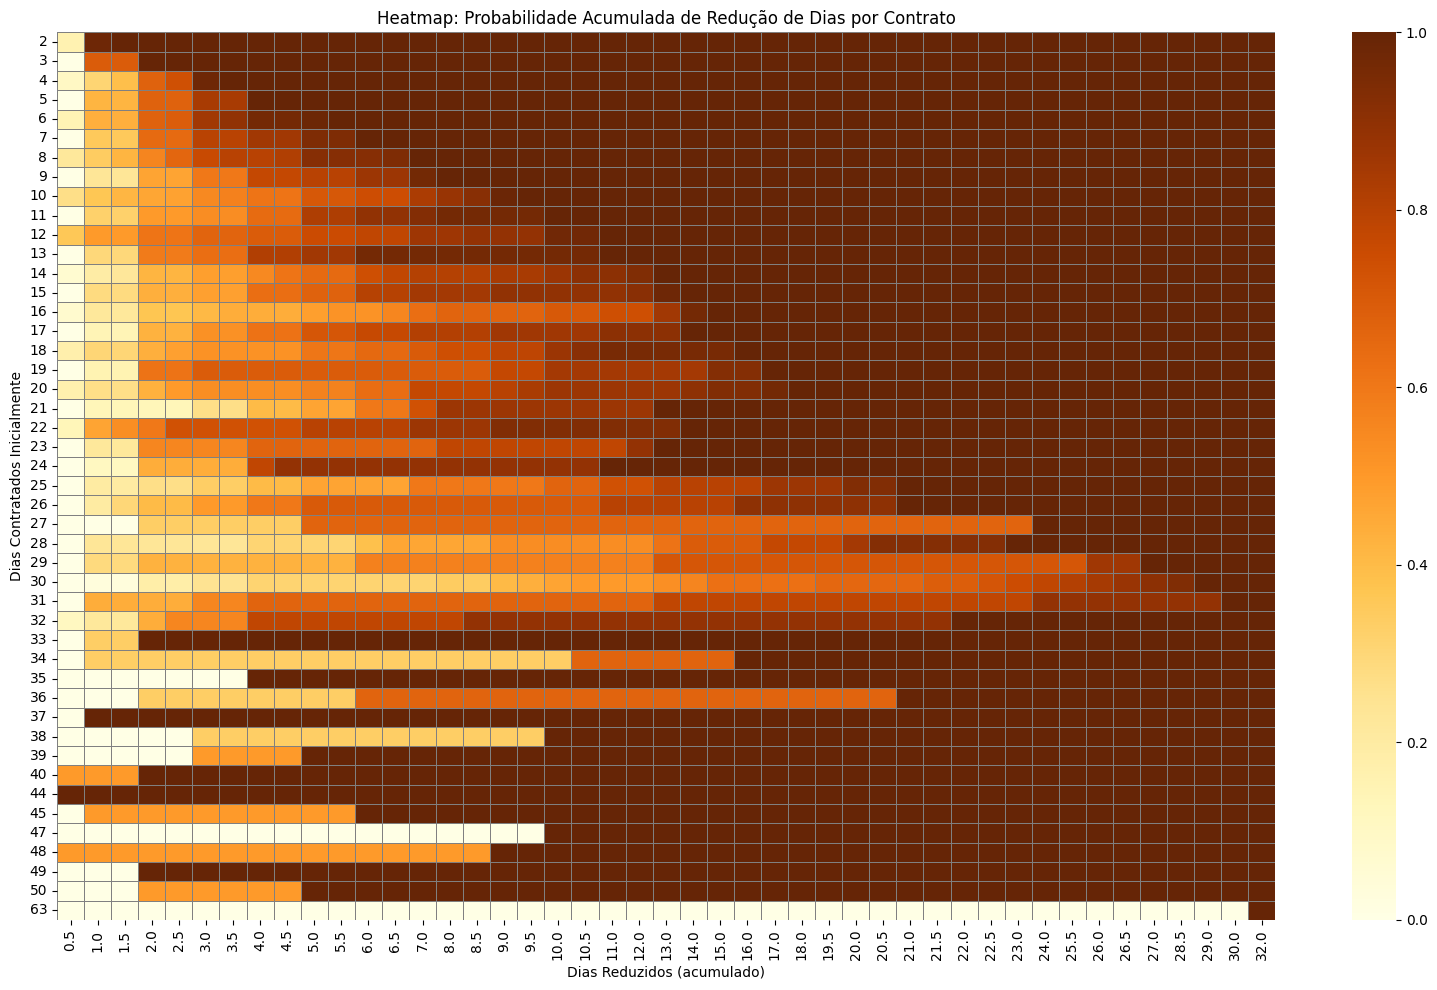

In [68]:
tabela_acumulada = tabela_pivot.cumsum(axis=1)


# Heatmap da versão acumulada
plt.figure(figsize=(16, 10))
sns.heatmap(tabela_acumulada, cmap='YlOrBr', linewidths=0.5, linecolor='gray')
plt.title('Heatmap: Probabilidade Acumulada de Redução de Dias por Contrato')
plt.xlabel('Dias Reduzidos (acumulado)')
for i in range(0, len(tabela_acumulada), 5):
    plt.axhline(i, color='gray', linewidth=0.5, linestyle='--')
plt.ylabel('Dias Contratados Inicialmente')
plt.tight_layout()
plt.show()


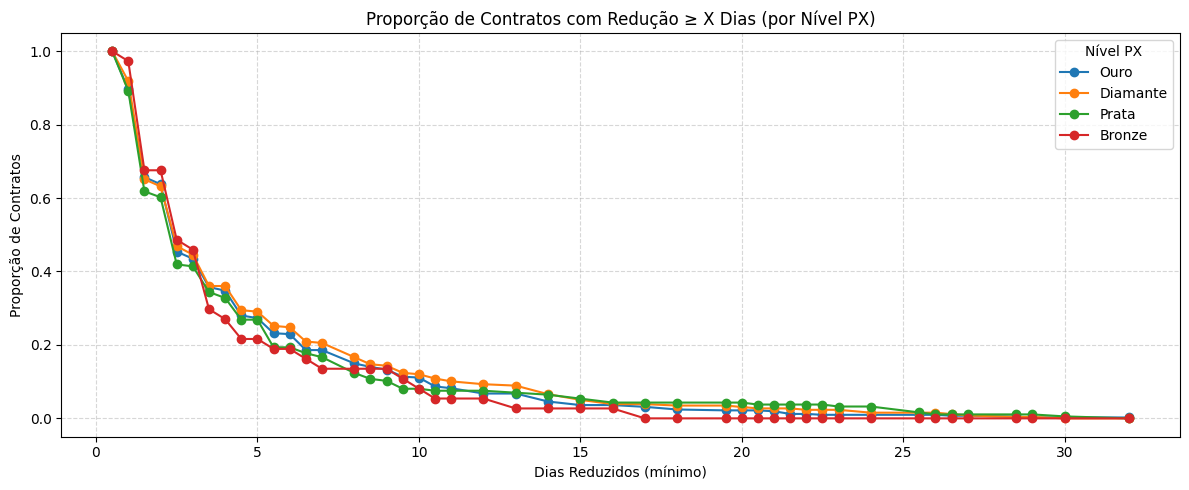

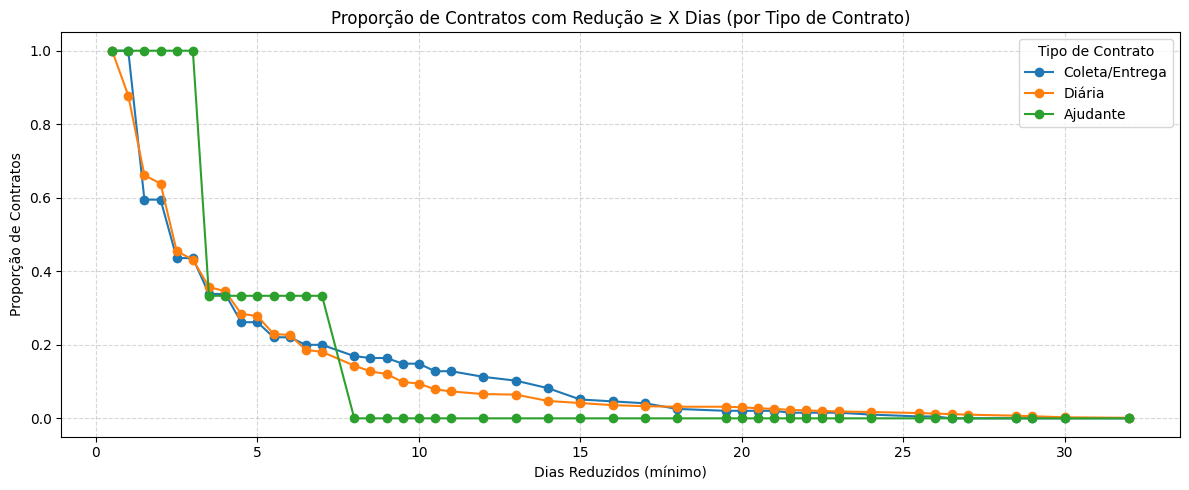

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Carrega o DataFrame original que já deve conter 'dias_reducao' e 'nivel_px' ou 'tipo'
df = df_original.copy()

# Arredonda os dias reduzidos para mais próximo de 0.5
df['dias_reducao_arredondado'] = (df['dias_reducao'] * 2).round() / 2

# Define os valores de corte
cortes = sorted(df['dias_reducao_arredondado'].unique())

# Inicializa dicionário para armazenar proporções por grupo
comparativo_px = []
comparativo_tipo = []

# Por nível PX
for nivel in df['nivel_px'].dropna().unique():
    subset = df[df['nivel_px'] == nivel]
    total = len(subset)
    proporcoes = [(corte, (subset['dias_reducao_arredondado'] >= corte).mean()) for corte in cortes]
    for corte, prop in proporcoes:
        comparativo_px.append({'grupo': nivel, 'corte': corte, 'proporcao': prop})

# Por tipo
for tipo in df['tipo'].dropna().unique():
    subset = df[df['tipo'] == tipo]
    total = len(subset)
    proporcoes = [(corte, (subset['dias_reducao_arredondado'] >= corte).mean()) for corte in cortes]
    for corte, prop in proporcoes:
        comparativo_tipo.append({'grupo': tipo, 'corte': corte, 'proporcao': prop})

# Converte em DataFrames
df_px = pd.DataFrame(comparativo_px)
df_tipo = pd.DataFrame(comparativo_tipo)

# Plota comparativo por nível PX
plt.figure(figsize=(12, 5))
for grupo in df_px['grupo'].unique():
    grupo_data = df_px[df_px['grupo'] == grupo]
    plt.plot(grupo_data['corte'], grupo_data['proporcao'], label=grupo, marker='o')
plt.title('Proporção de Contratos com Redução ≥ X Dias (por Nível PX)')
plt.xlabel('Dias Reduzidos (mínimo)')
plt.ylabel('Proporção de Contratos')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Nível PX')
plt.tight_layout()
plt.show()

# Plota comparativo por tipo de contrato
plt.figure(figsize=(12, 5))
for grupo in df_tipo['grupo'].unique():
    grupo_data = df_tipo[df_tipo['grupo'] == grupo]
    plt.plot(grupo_data['corte'], grupo_data['proporcao'], label=grupo, marker='o')
plt.title('Proporção de Contratos com Redução ≥ X Dias (por Tipo de Contrato)')
plt.xlabel('Dias Reduzidos (mínimo)')
plt.ylabel('Proporção de Contratos')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Tipo de Contrato')
plt.tight_layout()
plt.show()



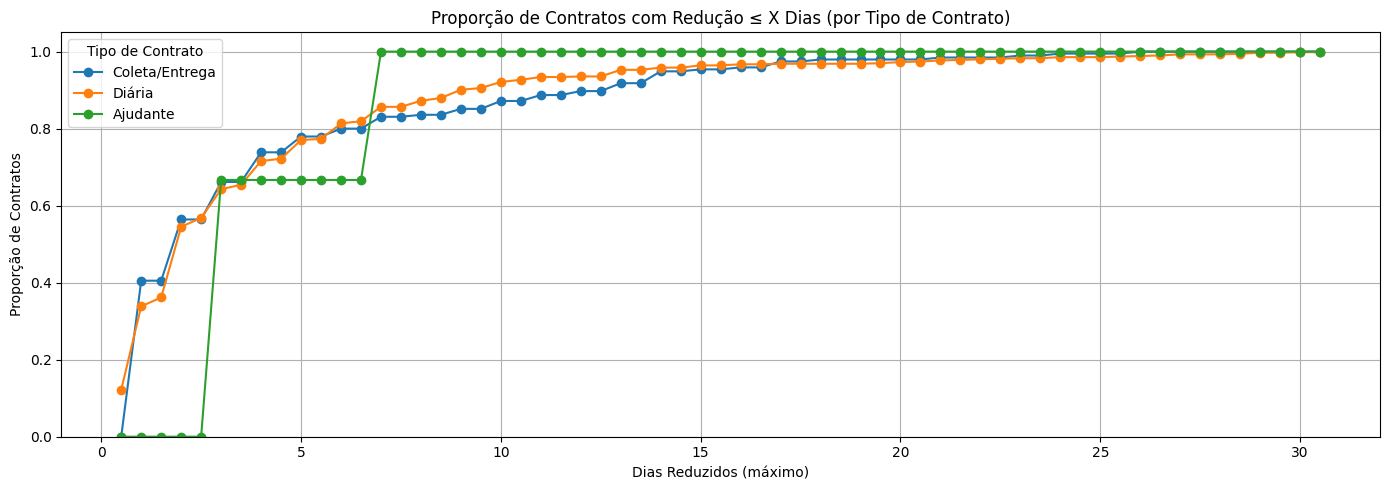

In [78]:
def plot_prob_reducao_menor_igual_por_tipo(df, tipos, cortes=np.arange(0.5, 31, 0.5)):
    plt.figure(figsize=(14, 5))

    for tipo in tipos:
        df_tipo = df[df['tipo'] == tipo]
        total = len(df_tipo)

        if total == 0:
            continue

        probs = [(df_tipo['dias_reducao'] <= corte).sum() / total for corte in cortes]
        plt.plot(cortes, probs, marker='o', label=tipo)

    plt.title('Proporção de Contratos com Redução ≤ X Dias (por Tipo de Contrato)')
    plt.xlabel('Dias Reduzidos (máximo)')
    plt.ylabel('Proporção de Contratos')
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.legend(title='Tipo de Contrato')
    plt.tight_layout()
    plt.show()
tipos_contrato = df_original['tipo'].unique()
plot_prob_reducao_menor_igual_por_tipo(df_original, tipos_contrato)


In [70]:
import pandas as pd
import numpy as np

def get_probabilidade_reducao(df, dias_iniciais):
    df_filtrado = df[df['contract_days_inicial'] == dias_iniciais]

    if df_filtrado.empty:
        return pd.DataFrame({'dias_reducao_min': [], 'probabilidade': []})

    max_reducao = int(df['dias_reducao'].max() * 2)  # passo de 0.5
    valores_reducao = np.arange(0.5, max_reducao + 0.5, 0.5)

    resultados = []
    total = len(df_filtrado)

    for v in valores_reducao:
        prob = (df_filtrado['dias_reducao'] >= v).sum() / total
        resultados.append({'dias_reducao_min': v, 'probabilidade': prob})

    return pd.DataFrame(resultados)

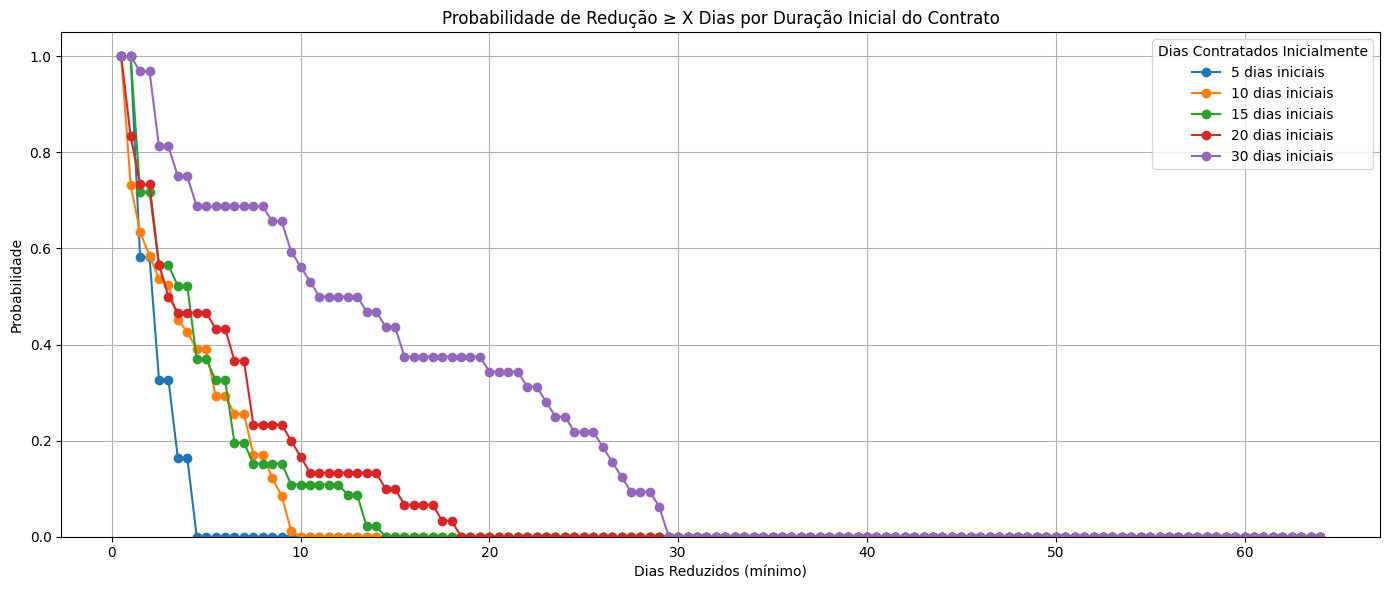

In [72]:
def plot_comparativo_probabilidade_reducao(df_original, lista_dias_iniciais):
    plt.figure(figsize=(14, 6))

    for dias in lista_dias_iniciais:
        df_probs = get_probabilidade_reducao(df_original, dias)
        plt.plot(df_probs['dias_reducao_min'], df_probs['probabilidade'], marker='o', label=f'{dias} dias iniciais')

    plt.title('Probabilidade de Redução ≥ X Dias por Duração Inicial do Contrato')
    plt.xlabel('Dias Reduzidos (mínimo)')
    plt.ylabel('Probabilidade')
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.legend(title='Dias Contratados Inicialmente')
    plt.tight_layout()
    plt.show()

plot_comparativo_probabilidade_reducao(df_original, lista_dias_iniciais=[5, 10, 15, 20, 30])


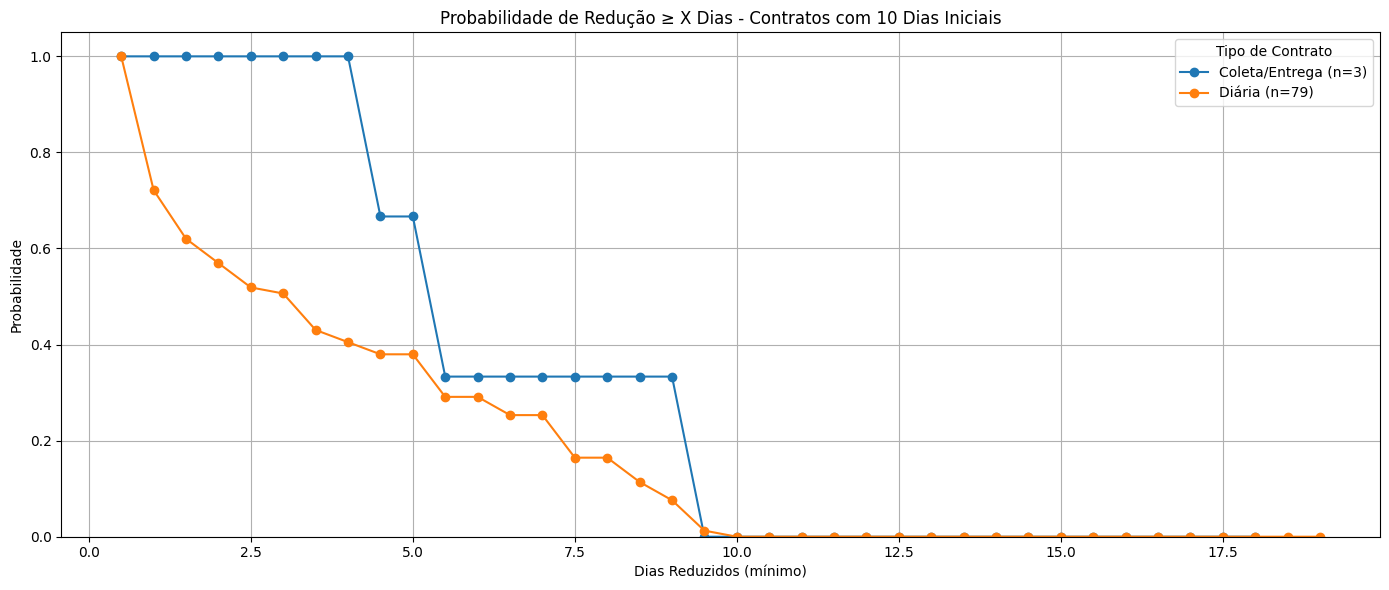

In [76]:
def plot_probabilidades_por_tipo(df, tipos, dias_iniciais):
    plt.figure(figsize=(14, 6))

    for tipo in tipos:
        df_tipo = df[(df['tipo'] == tipo) & (df['contract_days_inicial'] == dias_iniciais)]
        
        if df_tipo.empty:
            continue

        max_reducao = int(df_tipo['dias_reducao'].max() * 2)
        valores_reducao = np.arange(0.5, max_reducao + 0.5, 0.5)

        probabilidades = [
            (df_tipo['dias_reducao'] >= v).sum() / len(df_tipo)
            for v in valores_reducao
        ]

        plt.plot(valores_reducao, probabilidades, marker='o', label=f'{tipo} (n={len(df_tipo)})')

    plt.title(f'Probabilidade de Redução ≥ X Dias - Contratos com {dias_iniciais} Dias Iniciais')
    plt.xlabel('Dias Reduzidos (mínimo)')
    plt.ylabel('Probabilidade')
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.legend(title='Tipo de Contrato')
    plt.tight_layout()
    plt.show()

tipos_contrato = df_original['tipo'].unique()
plot_probabilidades_por_tipo(df_original, tipos_contrato, dias_iniciais=10)


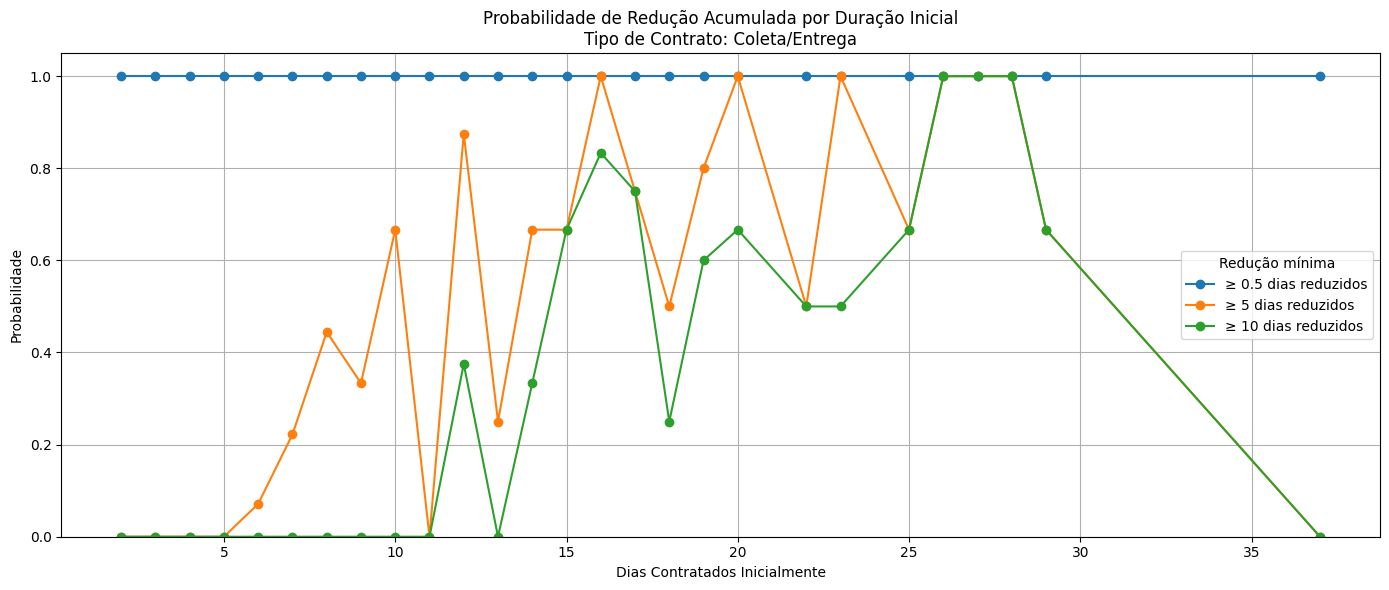

In [77]:
def plot_prob_acumulada_por_duracao(df, tipo_contrato, cortes=[0.5, 5, 10]):
    df_tipo = df[df['tipo'] == tipo_contrato].copy()
    dias_iniciais_unicos = sorted(df_tipo['contract_days_inicial'].unique())

    plt.figure(figsize=(14, 6))

    for corte in cortes:
        probs = []
        for dias in dias_iniciais_unicos:
            grupo = df_tipo[df_tipo['contract_days_inicial'] == dias]
            if len(grupo) == 0:
                probs.append(0)
            else:
                prob = (grupo['dias_reducao'] >= corte).sum() / len(grupo)
                probs.append(prob)
        
        plt.plot(dias_iniciais_unicos, probs, marker='o', label=f'≥ {corte} dias reduzidos')

    plt.title(f'Probabilidade de Redução Acumulada por Duração Inicial\nTipo de Contrato: {tipo_contrato}')
    plt.xlabel('Dias Contratados Inicialmente')
    plt.ylabel('Probabilidade')
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.legend(title='Redução mínima')
    plt.tight_layout()
    plt.show()

plot_prob_acumulada_por_duracao(df_original, tipo_contrato='Coleta/Entrega')


In [66]:
import pandas as pd

# Carregando o DataFrame original (com dias reduzidos e nível PX)
df = df_original.copy()

# Arredonda dias de redução para múltiplos de 0.5
df['dias_reducao'] = (df['dias_reducao'] * 2).round() / 2

# Define os níveis PX a considerar
niveis_px = df['nivel_px'].unique()

# Define os cortes que queremos comparar
cortes = [1, 2, 3, 5, 10, 15]

# Calcula proporção de contratos com redução >= corte, por nível PX
resultados_cortes = []
for corte in cortes:
    for nivel in niveis_px:
        total = len(df[df['nivel_px'] == nivel])
        com_reducao = len(df[(df['nivel_px'] == nivel) & (df['dias_reducao'] >= corte)])
        proporcao = com_reducao / total if total > 0 else 0
        resultados_cortes.append({'nivel_px': nivel, 'corte_dias': corte, 'proporcao': proporcao})

df_cortes = pd.DataFrame(resultados_cortes)

# Calcula mediana e percentis dos dias reduzidos por nível PX
df_resumo = df.groupby('nivel_px')['dias_reducao'].describe(percentiles=[.25, .5, .75])
df_resumo = df_resumo[['25%', '50%', '75%', 'mean']].rename(columns={
    '25%': 'percentil_25',
    '50%': 'mediana',
    '75%': 'percentil_75',
    'mean': 'media'
})

dataframe=df_cortes.merge(df_resumo, left_on='nivel_px', right_index=True, how='left')
dataframe


,nivel_px,corte_dias,proporcao,percentil_25,mediana,percentil_75,media
0,Ouro,1,0.896135,1.0,2.0,5.000,4.015700
1,Diamante,1,0.918605,1.0,2.0,5.375,4.325581
2,Prata,1,0.892473,1.0,2.0,5.000,4.016129
3,Bronze,1,0.972973,1.0,2.0,4.000,3.554054
4,Ouro,2,0.637681,1.0,2.0,5.000,4.015700
5,Diamante,2,0.631783,1.0,2.0,5.375,4.325581
6,Prata,2,0.602151,1.0,2.0,5.000,4.016129
7,Bronze,2,0.675676,1.0,2.0,4.000,3.554054
8,Ouro,3,0.434783,1.0,2.0,5.000,4.015700
9,Diamante,3,0.445736,1.0,2.0,5.375,4.325581


In [80]:
def calcular_risco_adiantamento(df, tipo_contrato, dias_contratados, dia_adiantado):
    df_tipo = df[(df['tipo'] == tipo_contrato) & 
                 (df['contract_days_inicial'] == dias_contratados)]

    if df_tipo.empty:
        return None

    dias_faltando = dias_contratados - dia_adiantado
    risco = (df_tipo['dias_reducao'] > dias_faltando).sum() / len(df_tipo)
    return round(risco, 3)
calcular_risco_adiantamento(df_original, 'Coleta/Entrega', dias_contratados=5, dia_adiantado=2)
# → Retorna algo como 0.24 (ou seja, 24% de chance de você estar adiantando mais do que deveria)

np.float64(0.207)

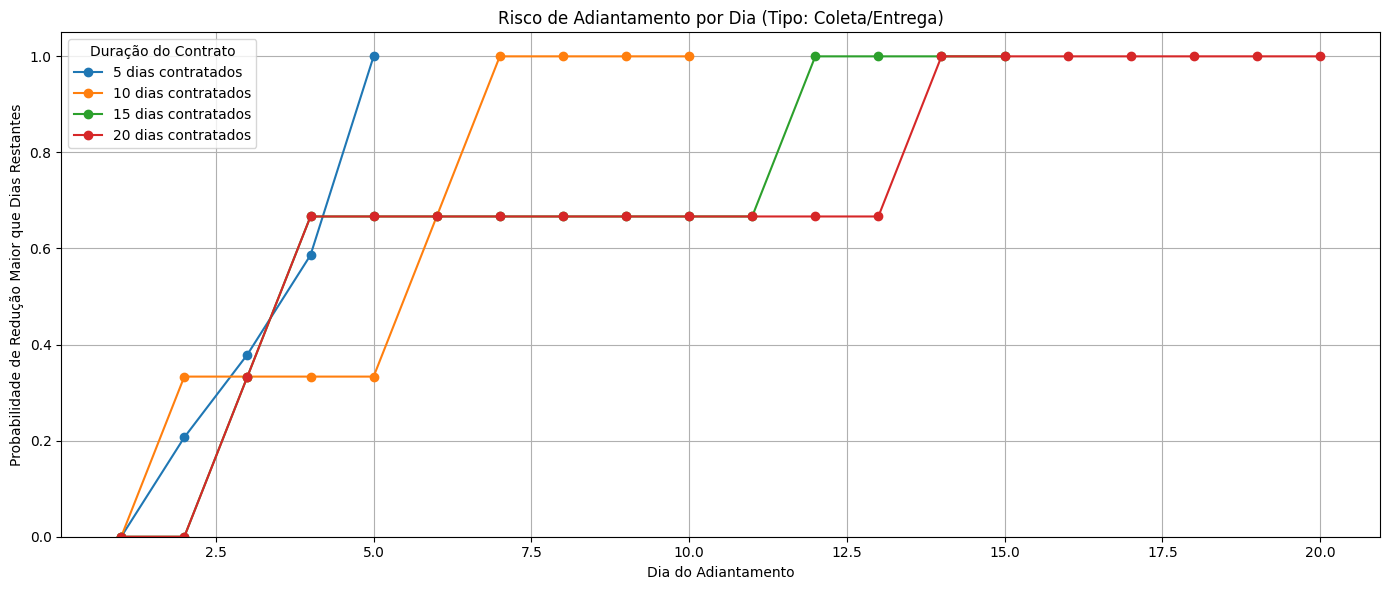

In [81]:
def plot_risco_adiantamento_por_duracao(df, tipo_contrato, duracoes=[5, 10, 15]):
    plt.figure(figsize=(14, 6))

    for dias_contratados in duracoes:
        df_tipo = df[(df['tipo'] == tipo_contrato) & 
                     (df['contract_days_inicial'] == dias_contratados)]

        if df_tipo.empty:
            continue

        dias_adiantados = range(1, dias_contratados + 1)
        riscos = []

        for dia_adiantado in dias_adiantados:
            dias_faltando = dias_contratados - dia_adiantado
            risco = (df_tipo['dias_reducao'] > dias_faltando).sum() / len(df_tipo)
            riscos.append(risco)

        plt.plot(dias_adiantados, riscos, marker='o', label=f'{dias_contratados} dias contratados')

    plt.title(f'Risco de Adiantamento por Dia (Tipo: {tipo_contrato})')
    plt.xlabel('Dia do Adiantamento')
    plt.ylabel('Probabilidade de Redução Maior que Dias Restantes')
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.legend(title='Duração do Contrato')
    plt.tight_layout()
    plt.show()
plot_risco_adiantamento_por_duracao(df_original, tipo_contrato='Coleta/Entrega', duracoes=[5, 10, 15, 20])


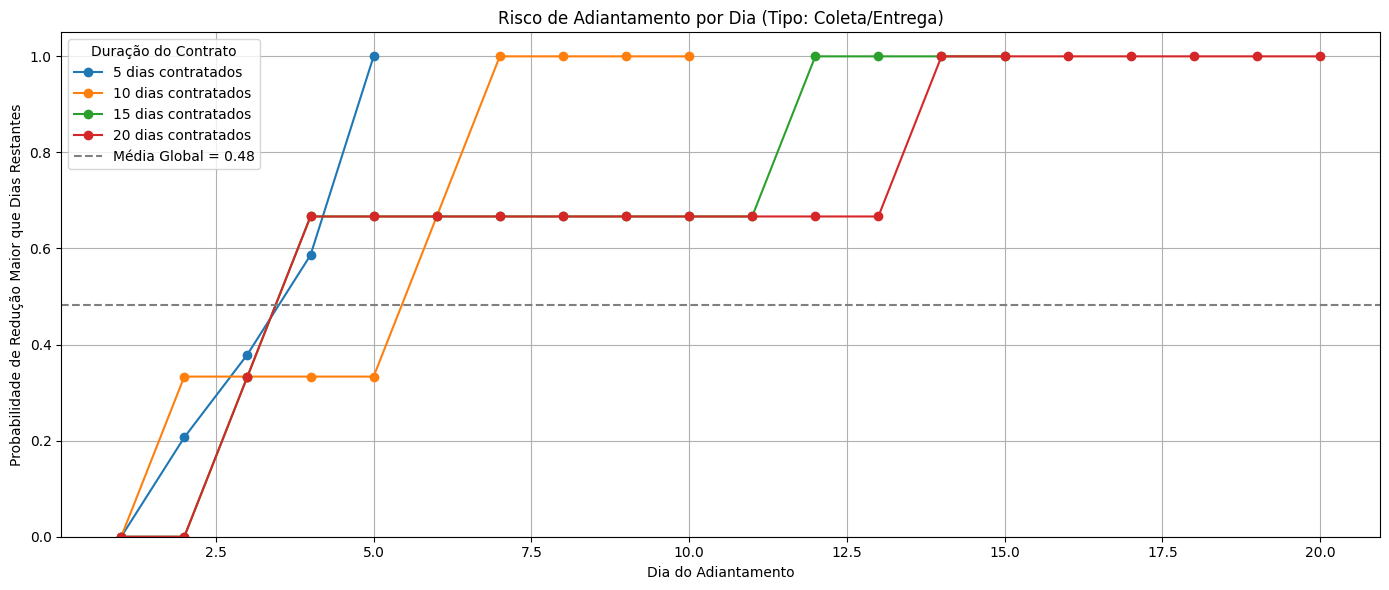

In [82]:
def plot_risco_adiantamento_com_media(df, tipo_contrato, duracoes=[5, 10, 15, 20]):
    plt.figure(figsize=(14, 6))

    # Filtrar apenas contratos do tipo
    df_tipo = df[df['tipo'] == tipo_contrato]

    # Calcular risco médio nacional (em todos os contratos desse tipo)
    riscos_globais = []
    for _, row in df_tipo.iterrows():
        dias_restantes = list(range(1, int(row['contract_days_inicial']) + 1))
        for d in dias_restantes:
            dias_faltando = row['contract_days_inicial'] - d
            risco = row['dias_reducao'] > dias_faltando
            riscos_globais.append(risco)

    media_global = round(np.mean(riscos_globais), 3)

    for dias_contratados in duracoes:
        grupo = df_tipo[df_tipo['contract_days_inicial'] == dias_contratados]
        if grupo.empty:
            continue

        dias_adiantados = range(1, dias_contratados + 1)
        riscos = []
        for dia_adiantado in dias_adiantados:
            dias_faltando = dias_contratados - dia_adiantado
            risco = (grupo['dias_reducao'] > dias_faltando).sum() / len(grupo)
            riscos.append(risco)

        plt.plot(dias_adiantados, riscos, marker='o', label=f'{dias_contratados} dias contratados')

    # Adiciona linha da média nacional
    plt.axhline(y=media_global, linestyle='--', color='gray', linewidth=1.5, label=f'Média Global = {media_global:.2f}')

    plt.title(f'Risco de Adiantamento por Dia (Tipo: {tipo_contrato})')
    plt.xlabel('Dia do Adiantamento')
    plt.ylabel('Probabilidade de Redução Maior que Dias Restantes')
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.legend(title='Duração do Contrato')
    plt.tight_layout()
    plt.show()
plot_risco_adiantamento_com_media(df_original, tipo_contrato='Coleta/Entrega', duracoes=[5, 10, 15, 20])


<Axes: >

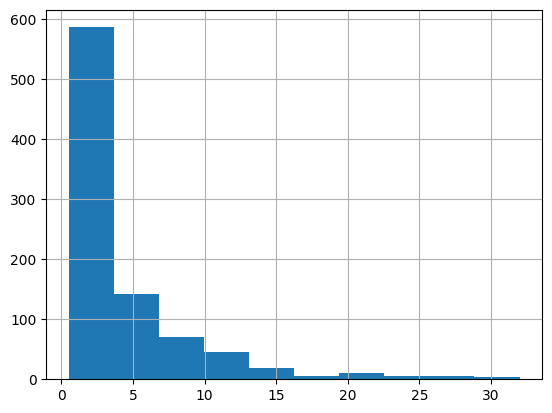

In [5]:
df_original.dias_reducao.hist()

In [5]:
df_original.dias_reducao.describe()

count    2169.000000
mean        4.365376
std         5.338504
min         0.500000
25%         1.000000
50%         2.000000
75%         5.000000
max        35.000000
Name: dias_reducao, dtype: float64

In [6]:
df_original.ano_mes.value_counts()

ano_mes
2025-01-01    455
2025-03-01    402
2025-02-01    400
2024-12-01    378
2024-11-01    378
2024-10-01     92
2025-04-01     55
2024-09-01      9
Name: count, dtype: int64

In [7]:
df_original.tipo.value_counts()

tipo
Diária            1785
Coleta/Entrega     374
Ajudante            10
Name: count, dtype: int64

In [8]:
df_original.nivel_px.value_counts()

nivel_px
Ouro        983
Diamante    661
Prata       423
Bronze      102
Name: count, dtype: int64

In [9]:
df_original.dias_reducao.describe()

count    2169.000000
mean        4.365376
std         5.338504
min         0.500000
25%         1.000000
50%         2.000000
75%         5.000000
max        35.000000
Name: dias_reducao, dtype: float64

In [10]:
df_original = df_original[['ano_mes', 'freight_id','tipo', 'nivel_px', 'dias_reducao']]
df_original = df_original.loc[df_original.ano_mes == '2025-04-01']
df_original = df_original.loc[df_original.ano_mes == '2025-03-01']
df_original = df_original.loc[df_original.ano_mes == '2025-02-01']


In [11]:
df_original.to_csv("src/data/df_original.csv")

In [12]:
df_original.head()

,ano_mes,freight_id,tipo,nivel_px,dias_reducao
73,2025-03-01,154390,Diária,Prata,1.0
74,2025-03-01,154389,Diária,Prata,1.0
75,2025-03-01,154339,Diária,Prata,2.0
76,2025-03-01,154324,Coleta/Entrega,Bronze,1.0
77,2025-03-01,154314,Diária,Diamante,2.0


# df_all

In [13]:
df_houve_reducao = df_original.copy()
df_houve_reducao['houve_reducao'] = 'sim'
df_houve_reducao.head()

,ano_mes,freight_id,tipo,nivel_px,dias_reducao,houve_reducao
73,2025-03-01,154390,Diária,Prata,1.0,sim
74,2025-03-01,154389,Diária,Prata,1.0,sim
75,2025-03-01,154339,Diária,Prata,2.0,sim
76,2025-03-01,154324,Coleta/Entrega,Bronze,1.0,sim
77,2025-03-01,154314,Diária,Diamante,2.0,sim


In [14]:
df_all = pd.read_csv("src/data/all_contracts.csv")
df_all = df_all.loc[:, ~df_all.columns.str.contains('^Unnamed')] 
df_all = df_all.dropna()

df_all['created_at'] = pd.to_datetime(df_all['created_at'])

df_all['ano_mes'] = df_all['created_at'].dt.to_period('M').dt.to_timestamp()

df_all = df_all.drop(columns=['created_at'])

df_all.head()

,freight_id,driver_id,tipo,nivel_px,ano_mes
1,23068,29889,Diária,Ouro,2023-05-01
2,11319,26879,Diária,Diamante,2022-11-01
3,11320,12224,Diária,Ouro,2022-11-01
4,8436,18608,Diária,Ouro,2022-09-01
5,11321,12623,Diária,Ouro,2022-11-01


In [16]:
# Merge usando left join pelas colunas especificadas
df_comparativo = df_all.merge(
    df_houve_reducao,
    how='left',
    on=['ano_mes', 'freight_id', 'tipo', 'nivel_px']
)

# Remover a coluna driver_id, se existir
if 'driver_id' in df_comparativo.columns:
    df_comparativo = df_comparativo.drop(columns=['driver_id'])

# Preencher valores nulos na coluna houve_reducao com 'nao'
df_comparativo['houve_reducao'] = df_comparativo['houve_reducao'].fillna('nao')

df_comparativo = df_comparativo[['ano_mes', 'tipo', 'nivel_px', 'houve_reducao']]
df_comparativo

,ano_mes,tipo,nivel_px,houve_reducao
0,2023-05-01,Diária,Ouro,nao
1,2022-11-01,Diária,Diamante,nao
2,2022-11-01,Diária,Ouro,nao
3,2022-09-01,Diária,Ouro,nao
4,2022-11-01,Diária,Ouro,nao
...,...,...,...,...
104126,2025-04-01,Coleta/Entrega,Ouro,nao
104127,2025-04-01,Coleta/Entrega,Diamante,nao
104128,2025-04-01,Coleta/Entrega,Bronze,nao
104129,2025-04-01,Coleta/Entrega,Diamante,nao
